# ----------- CSM - TP2 -----------
### [Enunciado]
https://2021moodle.isel.pt/pluginfile.php/1018318/mod_resource/content/2/trab2_csm_2021.pdf

<ul>
  <li>39205 Diogo Fernandes</li>
  <li>41543 Miguel Carreira</li>
</ul>

### [Introdução] 
Este trabalho tem como objetivo aplicar de forma prática a matéria lecionada na aula, nomeadamente os conceitos de compressão de dados sem perdas baseados na teoria da informação.
Assim sendo, este trabalho engloba os conceitos da codificação Huffman, tais como:
<ul>
    <li>Criação da tabela binária de Huffman com o código binário para cada símbolo de um dado conjunto;</li>
    <li>Codificação de sequências de símbolo em sequências de bits utilizando a tabela criada (mensagem codificada);</li>
    <li>Descodificação de uma sequência de bits em uma sequência de símbolos (mensagem descodificada);</li>
    <li>Comparação entre os códigos codificados e descodificados;</li>
    <li>Escrever e ler mensagens codificada dentro de um ficheiro;</li>
    <li>Realizar testes para diferentes ficheiros e códigos de símbolos e bits.</li>
</ul>

De forma a verificar que os resultados obtidos foram os esperados vamos também calcular métricas como a entropia e o número médio de bits por símbolo e calcular a eficiência, o tamanho do ficheiro e o tempo que a função demora a fazer a descodificação.

##### [Codificação Huffman]

A codificação Huffman é um caso especifico de uma codificação entrópica, com as seguintes caracteristicas:
* Método de codificação entrópica
* Código de comprimento variável (VLC)
* Método bottom-up
* Usado na compressão JPEG e MPEG

O algoritmo consiste em:
1. Colocar os símbolos numa lista por ordem decrescente de probabilidade
2. Escolher os dois simbolos com menor frequência e agrupálos num novo símbolo com probabilidade igual à soma destes dois.
3. Inserir o novo símbolo na lista ordenada.
4. Voltar ao ponto 2 até que cada a lista tenha apenas um símbolo.
5. Atribuir códigos partindo do ultimo símbolo criado.

Algumas restrições/desvantagens ao código de Huffman são:
* Conhecimento à priori da densidade de probabilidade da fonte.
* Esta informação tem de ser enviada no “header” do ficheiro

Muitas vezes não é possível são à priori as probabilidades de cada símbolo.

In [2]:
# importar as bibliotecas necessárias
import sys
import numpy as np
import matplotlib.pyplot as plt
import cv2 as cv
import re
import os
import math
from time import time

## Ler um ficheiro

Inicialmente vamos ler um ficheiro e armazenar a informação de **byte a byte, ou seja, cada símbolo será um inteiro de 8 bits**.  

Existem diferentes tipos de ficheiros, cada um com a sua informação organizada de diferentes formas (**por exemplo uma imagem é constituida por pixeis e cada pixel é representado por 3 bytes**). Para garantirmos que o nosso algoritmo funciona para **todo o tipo de ficheiro escrevemos 1 byte a 1 byte visto que é norma universal na leitura e escrita de ficheiros**. Outro problema que surgiria de fizessemos operações de leitura/escrita a mais de 1 byte, seriam situações onde um símbolo poderia conter parte da informação do cabeçalho do ficheiro, o que seria um problema. 

Para isso vamos utilizar `np.fromfile()` que permite converter os bits da mensagem em valores inteiros.

In [3]:
# Ler o ficheiro
#msg = np.fromfile("csm_tp2_resources/LenaColor.tif", dtype="uint8")
msg = np.fromfile("dadosTP2/DecUniversalDH.pdf", dtype="uint8") # dtype="uint8" -> inteiro 8 bits
print ( "Tamanho da imagem = " + str(len(msg)))

# Analisar a informação do ficheiro
print ( "array shape and dtype = " , msg.shape, ' ', msg.dtype)
print ( "Mostrar 10 primeiros elementos = " , msg[:10])
print ( "tipo da menssagem (numpy array) = ",type(msg))
print ( "Valor máximo da msg = " , max(msg))
print ( "valores não repetidos no array menssagem = " ,np.unique(msg))

Tamanho da imagem = 17524
array shape and dtype =  (17524,)   uint8
Mostrar 10 primeiros elementos =  [37 80 68 70 45 49 46 50 32 13]
tipo da menssagem (numpy array) =  <class 'numpy.ndarray'>
Valor máximo da msg =  255
valores não repetidos no array menssagem =  [  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17
  18  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35
  36  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53
  54  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71
  72  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89
  90  91  92  93  94  95  96  97  98  99 100 101 102 103 104 105 106 107
 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125
 126 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143
 144 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161
 162 163 164 165 166 167 168 169 170 171 172 173 174 175 176 177 178 179
 180 1

Através desta função lemos um ficheiro de 8 em 8 bits, ou seja de byte a byte. o dtype passou a uint8.

Podemos inspecionar algumas caracteristicas do array de inteiros gerado:

## Função Debug

Útil para comparar resultados. Será utilizado mais à frente para verificar as nossas funções estão a transmitir bem os ficheiros.

In [4]:
# Comparar para verificar se a mensagem foi bem transmitida
def func_controlo(mensagem_x, mensagem_y):
    """
    Verifica se a mensagem X e a mensagem Y são iguais (em termos de conteúdo)
    
    Parametros:
    ------------
    @mensagem_x -> elemento 1
    @mensagem_y -> elemento 2
    
    Condições:
    ------------
    @mensagem_x & @mensagem_y -> têm de ser do mesmo 'type'
    
    Retorna:
    ---------
    @igual -> Se as duas variáveis são iguais em termos do seu conteúdo

    """
    igual = False
    
    # Verifica logo se partilham o mesmo tipo -> Se não retorna Falso
    if not(isinstance(mensagem_x, type(mensagem_y))):
        print("A comparação tem de ser entre tipos iguais")
        return igual
    
    # Caso especial em que sejam arrays
    if(type(mensagem_x) == np.ndarray and type(mensagem_y) == np.ndarray):
        igual = np.allclose(mensagem_x, mensagem_y) # Retorna 'True' se todos os elementos do array estiver a 'True' -> forem iguais
    else:
        igual = (mensagem_x == mensagem_y)
        
    # Notificar o utilizador se a menssagem foi bem transmitida ou não
    if(igual):
        print("A mensagem foi bem transmitida")
        return igual
    else:
        print("Ocorreu um problema durante a transmissão da mensagem")
        return igual

Esta função permite-nos saber se a mensagem foi, de facto, bem transmitida,isto é, se quando comparadas a mensagem transmitida e a mensagem recebida, estas são iguais. Esta função no fim faz um print para notificar se a mensagem foi ou não bem transmitida.


# 1. Elaborar uma função (`tabela_s_f`) que gera uma tabela com o código binário para cada símbolo de um dado conjunto, usando o método de Huffman. 
Esta função tem como parâmetros de entrada um conjunto de símbolos e as suas probabilidades (substituido pelo número de ocorrências de cada símbolo, dado pelo seu histograma - Frequencia) e gera uma tabela que associa cada símbolo à sua frequência no conjunto recebido.


### Criar um dicionário com os símbolos e as respetivas frequências/probabilidades:
#### [Codificação Huffman] 
A codificação Huffman é um método de compressão que utiliza as probabilidades de ocorrência dos símbolos no conjunto de dados a ser comprimido, o que permite determinar códigos de tamanho variável utilizando um número menor de bits.
Para codificar uma mensagem de símbolo é necessário criar uma arvore binária de Huffman, esta é construída através da junção recursiva dos símbolos de menor probabilidade, até que todos os símbolos estejam unidos em símbolos auxiliares.
Seguidamente a árvore é  percorrida, sendo atribuído valores binários de 1 ou 0 para cada aresta, a codificação de cada símbolo é gerada a partir desse percurso binário.

Logo, código Huffman requer o conhecimento prévio das probabilidades de cada símbolo, já que vão ser agrupados segundo estas.
Assim como este irá agrupar 2 a 2 os símbolos com menor frequência (de forma iterativa), então torna-se mais rentável ordenarmos as frequências de forma decrescente.

No final deste passo pretende-se obter uma lista do tipo:

 - (s, f) -> ( símbolo, frequência )
 
Neste caso utilizamos as frequências porque remove a tarefa de calcular as probabilidades de cada símbolo, sendo que a frequência gera o mesmo resultado que as probabilidades.

Vamos utilizar um histograma para obter as frequências de cada símbolo.  
É de notar que cada símbolo corresponde a um inteiro de 8 bits, como visto anteriormente.

In [5]:
## Obter os símbolos e as probabilidades
#s_f = {}
#for i in range(len(histograma[0])):
#    if histograma[0][i] > 0:
#        simbolo = str(int(histograma[1][i]))
        #print(simbolo)
#        if simbolo in s_f:
#            print("Repetido")
#        s_f[simbolo] = int(histograma[0][i])

## Ordenar os símbolos de forma decrescente segundo as suas frequências
#s_f = sorted(s_f.items(), key=lambda x: x[1], reverse=True)
#print(len(s_f))
#histograma[0].shape, histograma[1].shape
#s_f

In [6]:
# Função para criar a tabela < Símbolo : Frequência >

def tabela_s_f(msg, debug=False):
   
    print("A construir a tabela de frequências...")
    # Obter os símbolos e as suas frequencias
    unique, counts = np.unique(msg, return_counts=True)
    s_f = dict(zip(unique, counts))
    #soma = sum(s_f.values())
    
    # Se a flag debug estiver a True, mostrar uma representação da tabela
    if debug:
        header = '{:^10}  |{:^15}'.format("Símbolo", "Frequência")
        print(header)
        print('-'*len(header))
        for (s, f) in s_f.items():
            print(' {:^10} |{:^15}'.format(s, f))

    # Ordenar os símbolos de forma decrescente segundo a sua frequência
    s_f = sorted(s_f.items(), key=lambda x: x[1], reverse=True)

    # Converter os símbolos para string
    #s_f = [(str(x[0]), x[1]) for x in s_f]
    
    return s_f
    
s_f = tabela_s_f(msg, True)    
#print(s_f)

A construir a tabela de frequências...
 Símbolo    |  Frequência   
----------------------------
     0      |      37       
     1      |      28       
     2      |      32       
     3      |      31       
     4      |      36       
     5      |      37       
     6      |      43       
     7      |      35       
     8      |      31       
     9      |      38       
     10     |      446      
     11     |      27       
     12     |      35       
     13     |      441      
     14     |      39       
     15     |      25       
     16     |      36       
     17     |      32       
     18     |      38       
     19     |      19       
     20     |      38       
     21     |      29       
     22     |      36       
     23     |      29       
     24     |      37       
     25     |      31       
     26     |      33       
     27     |      37       
     28     |      40       
     29     |      29       
     30     |      46       
    

A função `tabela_s_f` retorna um dicionário com os símbolos e a quantidade de ocorrências do mesmo. Como parâmetros são passados a mensagem em si e, caso o utilizador queira, pode dar um segundo argumento com o valor True, para que no fim a função faça um print da tabela com os símbolos e a quantidade de ocorrências que cada um tem, como verificado em cima. 

A soma de todas as frequências tem de ser igual ao número total de símbolos da mensagem.

(array([  37.,   28.,   32.,   31.,   36.,   37.,   43.,   35.,   31.,
          38.,  446.,   27.,   35.,  441.,   39.,   25.,   36.,   32.,
          38.,   19.,   38.,   29.,   36.,   29.,   37.,   31.,   33.,
          37.,   40.,   29.,   46.,   32., 1417.,   26.,   37.,   34.,
          40.,   28.,   34.,   40.,   27.,   26.,   40.,   30.,   48.,
          50.,   46.,  263., 1039.,  282.,  458.,  444.,  245.,  591.,
         416.,  452.,  254.,  136.,   29.,   29.,  121.,   30.,  107.,
          27.,   27.,   57.,   64.,   61.,   55.,   53.,  137.,   37.,
          50.,   40.,   44.,   33.,   33.,   44.,   55.,   53.,   65.,
          38.,   98.,   47.,   57.,   29.,   50.,   58.,   35.,   45.,
          48.,   42.,   27.,   49.,   47.,   26.,   29.,  146.,   95.,
          80.,  116.,  260.,   43.,   87.,   69.,  128.,  105.,   24.,
          62.,   64.,  196.,  187.,   76.,   35.,  113.,  112.,  190.,
          61.,   48.,   26.,   46.,   65.,   37.,   41.,   33.,   34.,
      

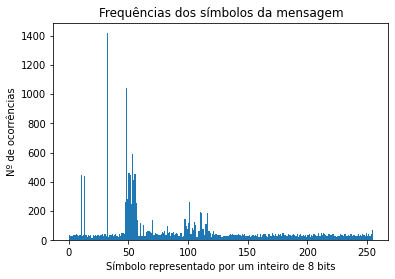

In [7]:
## Mostrar o histograma da mensagem (não funciona por algum motivo... shapes diferentes (256,) (255,))
#Ocorrencias em função do simbolo
def hist_msg(msg, nome=""):
    # Criar o histograma
    histograma = plt.hist(np.array(msg), 255, [0, 255]) # 255 para termos um bin do histograma para cada símbolo
    #Definir titulo
    
    if len(nome) != 0:
        plt.title(f"Frequências dos símbolos de {nome}")
    else:
        plt.title("Frequências dos símbolos da mensagem")
    # Definir os nomes dos eixos
    plt.xlabel("Símbolo representado por um inteiro de 8 bits")
    plt.ylabel("Nº de ocorrências")
    histograma;
    
    return histograma

hist_msg(msg)

A função `hist_msg()` possibilita a visualização do histograma de uma mensagem, isto é, permite visualizar de forma gráfica a ocorrência de cada um dos símbolos que a mensagem tem. 
Para esta função podem ser dados dois parâmetros, o primeiro parâmetro é a mensagem em si, o segundo parâmetro é opcional e permite dar um título ao histograma apresentado para facilitar a identificação.

In [8]:
#for i in range(len(histograma[1])):
#    print(str(histograma[1][i]) + "->" + str(histograma[0][i]))

<hr style="border-color: black">

Seguidamente vamos codificar então cada simbolo utilizando a codificação huffman, explicada anteriormente pata tal desenvolvemos dois métodos listado a seguir:

## Método 1 - Através da classe Node

### Tarefas
  1. Criar uma classe que represente um nó da árvore
  2. Calcular as frequências/probabilidades de cada símbolo
  3. Construir a árvore
  4. Criar a tabela de códigos baseado na árvore

## 1.1 Criar uma classe que represente um nó da árvore

Esta classe vai ser bastante útil para guardar com facilidade os descendentes de um nó.  
Assim, quando posteriormente tivermos de ler a árvore da raíz até ás folhas (para codificarmos cada símbolo), vamos poder navegar facilmente através dos descendentes.

Assim a nossa classe deverá ter:
 1. Atributos para os dois descendentes do nó (esquerda e direita)
 2. Método para obtermos esses descendentes
 

No final do código iremos obter um nó raíz com a possibilidade de aceder a todos os nós da árvore. (sendo necessário para podermos codificar cada símbolo).

In [9]:
# Criar uma classe que represente um Node
# Útil para armazenar os filhos de cada Node
class Node:
    def __init__(self, left=None, right=None):
        self.left = left
        self.right = right
    
    def children(self):
        return (self.left, self.right)

    def __str__(self):
        #output = f"\r\n-O-\r\n| |\r\n{self.left} {self.right}"
        #return output
        return '%s_%s' % (self.left, self.right)

## 1.2 Calcular as frequências/probabilidades de cada símbolo

O código Huffman requer o conhecimento prévio das probabilidades de cada símbolo, já que vão ser agrupados segundo estas.
Como o código Huffman irá agrupar 2 a 2 os símbolos com menor frequência (de forma iterativa), então dá jeito ordenarmos as frequências de forma decrescente.

No final deste passo pretende-se obter uma lista do tipo:

 - (s, f) -> ( símbolo, frequência )

In [10]:
# Mensagem a transmitir
#mensagem = 'BCAADDDCCACACAC'
mensagem = "Ajuda-te a ti mesmo: assim todos te ajudarão. Princípio do amor ao próximo."

In [11]:
# Admite-se que já temos acesso direto aos símbolos
# 1. Calcular a frequência de cada símbolo (dicionário -> (símbolo, frequência)) ou seja contar quantas vezes ele aparece na menssagem
freq = {}
for ch in mensagem:
    if ch in freq:
        freq[ch] += 1
    else:
        freq[ch] = 1

# Ordenar de forma decrescente em função da frequência de cada símbolo
freq = sorted(freq.items(), key=lambda x: x[1], reverse=True)
#Imprimir o array de frequencias do tipo ('simbolo', frequencia)
freq

[(' ', 12),
 ('o', 9),
 ('a', 7),
 ('i', 5),
 ('m', 5),
 ('d', 4),
 ('t', 4),
 ('s', 4),
 ('r', 4),
 ('e', 3),
 ('j', 2),
 ('u', 2),
 ('.', 2),
 ('p', 2),
 ('A', 1),
 ('-', 1),
 (':', 1),
 ('ã', 1),
 ('P', 1),
 ('n', 1),
 ('c', 1),
 ('í', 1),
 ('ó', 1),
 ('x', 1)]

## 1.3 Construir a árvore

Com o conceito Node criado e as frequências calculadas, podemos começar a construir a árvore binária.
O objetivo é passarmos do número `N` de símbolos para apenas 1 ( nó raíz ).
Para isso temos de seguir os passos definidos pelo código Huffman:
 1. Obter os 2 símbolos com menos frequência
 2. Remover esses símbolos da lista (s, f)
 3. Criar um node com as características dos 2 símbolos (concatenar os símbolos e somar as suas frequências)
 4. Adicionar esse node à lista
 5. Ordenar a lista de forma decrescente (segundo a frequência)
 6. Repetir os passos anteriores até atingirmos o nó raiz
 
Na prática o que vamos fazer é criar um node que contenha todos os símbolos de forma a mais tarde podermos descer a árvore e irmos atribuindo bits conforme.

Exemplo final da árvore (já com os códigos que serão implementados mais à frente):

 - abdc -> Nó raíz
     - ab : "0" -> Nó intermédio
     - dc : "1" -> Nó intermédio
         - a : "00" -> Símbolo
         - b : "01" -> Símbolo
         - d : "10" -> Símbolo
         - d : "11" -> Símbolo

In [12]:
#%%timeit
tree = freq

# Construir a árvore
type(tree)

while len(tree) > 1:
    # Obter os 2 símbolos com menor frequência
    (key1, value1) = tree[-1]
    (key2, value2) = tree[-2]
    # Retirar os símbolos dos nodes
    tree = tree[:-2]
    # Criar um novo node a partir dos 2 símbolos
    node = Node(key1, key2)
    # Adicionar o novo node à árvore
    tree.append((node, value1 + value2))
    # Ordenar a lista denovo de forma descrescente
    tree = sorted(tree, key=lambda x: x[1], reverse=True)

# Visualizar árvore
tree

# Visualizar Root Node
#print(tree[0][0])

[(<__main__.Node at 0x124ab02b0>, 75)]

## 1.4 Criar a tabela de códigos baseado na árvore

Seguidamente vamos pegar na árvore construída anteriormente e vamos partir do nó raíz até chegarmos aos símbolos.  

Cada vez que descermos um nível da árvore atribuimos um bit a cada _node_. 

Como sabemos que cada _node_ apenas tem 2 descendentes, então atribuímos `0` ao descendente à esquerda e atribuímos `1` ao descendente à direita.

Quando chegarmos ao nível dos símbolos paramos a codificação.
Assim sendo o código gerado vai ser o conjuntos de bits percorridos até chegar ao simbolo desejado.

In [13]:
#%%timeit

# Construir a tabela do codificador
def huffman_code_tree(node, bitString=""):
    # Se o node for uma string, chegámos a um símbolo (Leaf Node)
    if type(node) == str:
        return {node: bitString}
    # Codificar os nodes descendentes
    (left, right) = node.children()
    d = dict()
    d.update(huffman_code_tree(left, bitString + "0"))
    d.update(huffman_code_tree(right, bitString + "1"))
    
    # retornar dicionário
    return d

huffman = huffman_code_tree(tree[0][0])

# Mostrar tabela de codificação
#print(' Char | Huffman code ') 
#print(" {:<4} | {:>13}".format("Char", "Huffman code"))
#print('----------------------')
#for (char, frequency) in freq:
#    print(' {:<4} |{:>13}'.format(char, huffman[char]))

In [14]:
freq

[(' ', 12),
 ('o', 9),
 ('a', 7),
 ('i', 5),
 ('m', 5),
 ('d', 4),
 ('t', 4),
 ('s', 4),
 ('r', 4),
 ('e', 3),
 ('j', 2),
 ('u', 2),
 ('.', 2),
 ('p', 2),
 ('A', 1),
 ('-', 1),
 (':', 1),
 ('ã', 1),
 ('P', 1),
 ('n', 1),
 ('c', 1),
 ('í', 1),
 ('ó', 1),
 ('x', 1)]

## Método 2 - Alternativa à solução dos objetos

Nesta solução não temos o procedimento de construir a árvore e depois descê-la e ir codificando os símbolos conforme. Em vez disso vamos codificando os símbolos à medida que vamos construindo as árvores. Desta forma assim que a árvore esteja construída também os códigos de cada símbolo.
<hr style="border-color: black">


**Para utilizarmos este método primeiro precisamos de ter 3 contentores de dados:**
   * Um contentor `cods` que guarde os códigos de cada símbolo.
   * Um contentor `probs` que tenha as probabilidades de cada símbolo (ou conjunto de símbolos).
   * Um contentor `simbolos` que guarde as relações entre símbolos (se estão agrupados ou não).
<hr style="border-color: black">

**O raciocinio por detrás deste método passa por:**
   1. Obter os dois símbolos com menor frequência.
       1. Para tal podemos obter uma ordenação hipotetica que nos indique os indices que deveriam estar no principio da lista para que esta mostrasse as frequências de forma crescente. Desta maneira o array probs não é alterado porque estamos apenas a trabalhar com indices e não com os próprios valores.
   2. Adicionar um bit a "0" ao primeiro símbolo e um "1" ao segundo. (`cods`)
       1. É de notar que, por exemplo, se tivermos (A, (B, C)), ou seja, o símbolo B e C estão juntos, então quando juntarmos A,B,C teremos que adicionar um "0" a |A| e um "1" tanto a |B| como a |C|. Portanto na verdade vamos adicionar bits a símbolos ou conjunto de símbolos.
   3. Somar as probabilidades dos dois símbolos. (`probs`)
   4. Remover as probabilidades dos símbolos que foram unidos. (`probs`)
   5. Registar a união entre dois símbolos. (`simbolos`)
       1. Com esta informação garantimos que quanto estivermos na parte de adicionar bits, estes são adicionados a todos os elementos de um conjunto de símbolos.
   6. Remover os símbolos que foram unidos. (`simbolos`)
   7. Repetir os passos anteriores até que só exista um conjunto de símbolos que contenha tudo.
<hr style="border-color: black">


**Algumas notas:**
   * A lista `probs` e `simbolos` estão sempre em **sincronia**, isto é, vão ter sempre **tamanho igual** um ao outro e a probabilidade numa dada posição da lista `probs` corresponde ao símbolo/conjunto de símbolos na mesma posição da lista `simbolos`.
   e.g. 
     * **1ª iteração** [6 5 4] - [(0,), (1,), (3, 2)]         (frequências - relações)
     * **2ª iteração** [6 9] - [(0,), (3, 2, 1)]         (frequências - relações)
   * Na verdade quando é para remover 2 elementos tanto de `probs`como de `simbolos` apenas um é removido porque o outro passa a agregar as informações dos dois.
   * Os procedimentos aplicam-se da mesma maneira para símbolos como para conjuntos de símbolos  . 

In [15]:
#%%timeit

def gen_huff_table(s_f, debug=False):
    """
    Gera uma tabela de codificação Huffman tendo como chaves os símbolos e como valores os códigos.
    
    Parametros:
    ----------
    @s_f -> Dicionário com as associações de símbolos com respetivas frequencias/probabilidades
    @debug -> flag que indica se queremos uma visualização da tabela resultante
    
    Condições:
    ----------
    @s_f -> Dicionário (símbolo : frequência)
    @debug -> Boolean
    
    Retorna:
    ---------
    @dic_codificado -> tabela de codificação (símbolo : código)
    
    Nota:
    ---------
    ====================================
    Para utilizarmos este método primeiro precisamos de ter 3 contentores de dados:

    Um contentor <cods> que guarde os códigos de cada símbolo.
    Um contentor <probs> que tenha as probabilidades de cada símbolo (ou conjunto de símbolos).
    Um contentor <simbolos> que guarde as relações entre símbolos (se estão agrupados ou não).
    ====================================
    O raciocinio por detrás deste método passa por:

    Obter os dois símbolos com menor frequência.
        Para tal podemos obter uma ordenação hipotetica que nos indique os indices que deveriam estar no principio da lista para que esta mostrasse as frequências de forma crescente. Desta maneira o array probs não é alterado por estamos apenas a trabalhar com indices e não com os próprios valores.
    Adicionar um bit a "0" ao primeiro símbolo e um "1" ao segundo. (cods)
        É de notar que, por exemplo, se tivermos (A, (B, C)), ou seja, o símbolo B e C estão juntos, então quando juntarmos A,B,C teremos que adicionar um "0" a |A| e um "1" tanto a |B| como a |C|. Portanto na verdade vamos adicionar bits a símbolos ou conjunto de símbolos.
    Somar as probabilidades dos dois símbolos. (probs)
    Remover as probabilidades dos símbolos que foram unidos. (probs)
    Registar a união entre dois símbolos. (simbolos)
        Com esta informação garantimos que quanto estivermos na parte de adicionar bits, estes são adicionados a todos os elementos de um conjunto de símbolos.
    Remover os símbolos que foram unidos. (simbolos)
    Repetir os passos anteriores até que só exista um conjunto de símbolos que contenha tudo.
    
    ====================================
    Algumas notas:

    A lista probs e simbolos estão sempre em sincronia, isto é, vão ter sempre tamanho igual um ao outro e a probabilidade numa dada posição da lista probs corresponde ao símbolo/conjunto de símbolos na mesma posição da lista simbolos e.g.
    1ª iteração [6 5 4] - [(0,), (1,), (3, 2)] (frequências - relações)
    2ª iteração [6 9] - [(0,), (3, 2, 1)] (frequências - relações)
    Na verdade quando é para remover 2 elementos tanto de probscomo de simbolos apenas um é removido porque o outro passa a agregar as informações dos dois
    Os procedimentos aplicam-se da mesma maneira para símbolos como para conjuntos de símbolos
    ====================================
    """
    cods = ['']*len(s_f) # Codigos de cada símbolo
    probs = [x[1] for x in s_f] # Probabilidades de cada símbolo
    simbolos = [(i,) for i in range(len(s_f))] # Símbolos (indices)
    #cods, probs, simbolos


    # Criar a tabela para codificação Huffman
    while(len(probs) > 1):
        # Obter uma ordenação hipotetica dos indices
        idx = np.argsort(np.array(probs))
        #print("idx: " + str(idx))

        # Obter os 2 primeiros indices (indicam os 2 simbolos com menor frequencia)
        i0 = idx[0]
        i1 = idx[1]
        #print("i0 -> " + str(i0))
        #print("i1 -> " + str(i1))

        # Fornecer 1 bit para os nodes envolvidos
        for i in simbolos[i0]:
            #print("i: " + str(i))
            cods[i] = "0" + cods[i]

        for k in simbolos[i1]:
            #print("k: " + str(k))
            #print("cods: " + str(cods[k]))
            cods[k] = "1" + cods[k]  

        # Somar as probabilidades dos 2 símbolos
        probs[i0] = probs[i0] + probs[i1]

        # Remover uma das probabilidades dos símbolos da lista (o segundo passa a representar a junção dos dois)
        probs = np.delete(probs, i1)
        #probs.remove(probs[i1])


        # Guardar o Node criado pela junção de 2 símbolos
        simbolos[i0] = simbolos[i0] + simbolos[i1]

        # Remover um dos símbolos da lista (o segundo passa a representar a junção dos dois)
        simbolos.remove(simbolos[i1])
        #print(probs)
        #print(simbolos)
    
    
    
    # Construir um dicionário com os símbolos e os respetivos códigos
    dic_codificado = dict(zip(np.array(s_f)[:, 0], cods))
    
    # Se a flag debug estiver a True, mostrar uma representação da tabela Huffman
    if debug:
        header = '{:^10}  |{:^15}'.format("Símbolo", "Código")
        print(header)
        print('-'*len(header))
        for (s, c) in dic_codificado.items():
            print(' {:<10} |{:>15}'.format(s, c))
    
    return dic_codificado
#dic_cod

dic_cod = gen_huff_table(s_f, True)

 Símbolo    |    Código     
----------------------------
 32         |           1101
 48         |           1000
 53         |          10110
 50         |          01000
 55         |          00111
 10         |          00110
 51         |          00100
 13         |          00011
 54         |          00000
 49         |         101001
 47         |         100100
 101        |         011110
 56         |         011010
 52         |         010111
 110        |        1111101
 116        |        1111010
 111        |        1110111
 97         |        1010111
 70         |        1001111
 57         |        1001101
 105        |        0111000
 60         |        0101100
 100        |        0101010
 114        |        0100100
 115        |        0010111
 62         |        0001000
 106        |        0000101
 82         |       11111001
 98         |       11110010
 103        |       11100101
 99         |       11001010
 112        |       10111110
 104        | 

A função `gen_huff_table()` permite fazer a tabela de codificação de uma certa mensagem através do método de Huffman. Contrariamente ao método utilizado fora do contexto de programação, este método codifica os símbolos à medida que cria a árvore. Sendo assim, ao juntar dois símbolos, este método acrescenta de imediato à sua codificação um bit com o valor de '1' ou '0'. É de notar que quando se aglutina dois elementos, esses por sua vez podem ser também um conjunto de símbolos, portanto o acréscimo é feito a nível elementar. Esta função pode receber dois parâmetros. O primeiro parâmetro é um dicionário com os símbolos e a sua quantidade de ocorrências e o segundo parâmetro é opcional e, caso seja passado o valor True, então é feito o print de uma tabela que contém os símbolos e as suas respetivas codificações.

# 2. Codificador Huffman 

### Elabore uma função (encode_huff) que dada uma mensagem (sequência de símbolos) e a tabela da ponto anterior, retorne uma sequência de bits com a mensagem codificada.


Agora precisamos de uma função que receba uma mensagem (sequencia de simbolos) e a tabela de codificação criada a partir da mesma e codifique a mensagem (retornar uma sequência de bits).

Assim esta função tem que:
   1. Ler um símbolo.
   2. Obter a sequência de bits associada a esse símbolo.
   3. Adicionar a uma string que terá a mensagem codificada.
   4. Repetir os passos anteriores até não existir mais símbolos.

In [16]:
# Visualizar mais uma vez a mensagem e a tabela
#msg, dic_cod

In [17]:
# Função para codificar a mensagem
def encode_huff(mensagem, tabela):
    """
    Codificação Huffman. Pega num conjunto de símbolos (mensagem) e obtem a sequência de bits associada (utilizando a tabela).
    
    Parametros:
    ----------
    @mensagem -> array com a mensagem
    @tabela -> dicionário com as regras de codificação
    
    Condições:
    ----------
    @mensagem -> Array ou Lista
    @tabela -> Dicionário (dict)
    
    Retorna:
    ---------
    @sequencia -> sequencia de bits da tabela codificada (formato 'string')
    
    Nota:
    ---------
    Esta função aplica diretamente os conceitos de um dicionário:
    1. Lemos um símbolo da mensagem
    2. Procuramos no dicionário o código respetivo ao símbolo
    3. Adicionamos o código à mensagem codificada
    4. Repetir os passos anteriores até percorrermos toda a mensagem
    
    """
    sequencia = ""
    for ch in mensagem:
        #print(ch)
        sequencia += tabela[ch]
    
    return sequencia

A função `encode_huff()` codifica uma mensagem consoante uma tabela de quantificação. Esta função tem dois parâmetros, sendo o primeiro a mensagem a ser codificada e o segundo o critério de codificação, ou seja, a tabela que contém a codificação para certos símbolos.

In [18]:
# Testes ao codificador
#msg, dic_cod

In [19]:
codific = encode_huff(msg, dic_cod)
#msg, codific

In [20]:
print ("Tamanho da mensagem codificada " + str(len(codific)))

Tamanho da mensagem codificada 123844


# 3. Processamento da mensagem codificada

De forma a existir coerência na escrita e leitura da mensagem num ficheiro, temos de definir um **protocolo**.
Este protocolo define que tanto a escrita com a leitura é feita **byte a byte** (o que nos permitirá generalizar o tipo de ficheiros que poderemos transmitir).
Se por acaso a mensagem não puder ser dividida em blocos de 8 bits (byte) teremos que acrescentar **bits redundantes**. Adicionalmente teremos que adicionar um **_header_** à mensagem com mais um número de bits que nos indiquem quantos bits redudantes foram adicionados à mensagem.

Este protocolo define então que uma mensagem tem:
 * Tamanho **divisivel por 8**
 * Um **cabeçalho que indique quantos bits redudantes foram adicionados** à mensagem
 
Da parte do recetor poderá então ser lido o cabeçalho da mensagem e de seguida removidos os bits redudantes da mensagem.

Nesta secção será feito então:
 1. Protocolo de transmissão da tabela de codificação
 2. Processamento da mensagem para que respeite o protocolo defino entre o emissor e o recetor. (bit stuffing)
 3. Divisão da mensagem em blocos de 8 bits
 4. Escrita desses blocos num ficheiro (escrita é feita bloco a bloco)
 5. Leitura do contéudo do ficheiro bloco a bloco
 6. Unir todos os blocos para obtermos a mensagem codificada
 7. Processar a mensagem segundo o protocolo definido (ler o cabeçalho e remover os bits redudantes)

### 3.1 Protocolo de transmissão da tabela de codificação

O algoritmo de codificação Huffman requer que o recetor tenha conhecimento da tabela que foi usada para codificar a mensagem (de maneira a poder descodificá-la).
Como tal quando enviarmos a mensagem para o recetor teremos que transmitir também essa tabela.

Esta transmissão tem que seguir um protocolo que seja conhecido tanto pelo emissor como pelo recetor.
Este protocolo segue então as seguintes regras:
 1. É informado o número de símbolos que a tabela codifica
 2. É indicado o número de bits que foram usados para o símbolo
 3. É introduzido o símbolo
 4. É indicado o número de bits que foram usados para o código do símbolo
 5. É introduzido o código do símbolo
 6. Repete-se os passos 2 a 5 durante o número de símbolos lidos no inicio do cabeçalho

### 3.1.1 Protocolo

In [21]:
# Definir o protocolo (bits dedicados para cada informação acerca do dicionário)
protocolo_tabela = {
    'n_simbolos': math.ceil(np.log2(len(dic_cod))), # bits equivalentes ao número de símbolos únicos da mensagem
    'n_bits_para_tamanho_do_codigo'  : 8 # 8 bits dedicados para informar o número de bits do código
}

print(protocolo_tabela)

# Mostrar o protocolo
print(f"Protocolo: {protocolo_tabela}")


{'n_simbolos': 8, 'n_bits_para_tamanho_do_codigo': 8}
Protocolo: {'n_simbolos': 8, 'n_bits_para_tamanho_do_codigo': 8}


Assim aqui é calculado quantos bits serão necessários para informar ao recetor quantos símbolos diferentes existem numa certa mensagem. Também é declarado o número de bits para informar quantos bits foram necessários para codificar um certo símbolo, dado o protocolo a seguir apresentado. Este protocolo terá utilidade para fazer a codificação da tabela de codificação. Este método faz com que o recetor não tenha que conhecer previamente a tabela de codificação, pois esta é enviada no cabeçalho da mensagem, apenas terá que saber o protocolo que foi usado.

### 3.1.2 Codificação da tabela

In [22]:
# Aplicar o protocolo de transmissão da tabela

def encode_table(tabela, protocolo):
    """
    Codifica uma tabela de codificação Huffman segundo o protocolo definido.
    
    
    Protocolo:
    ----------
    Nº Símbolos -> Primeiro símbolo -> Nº bits do código do simbolo -> Código ...
    
    Parametros:
    ----------
    @tabela -> tabela com os códigos associados a cada símbolo
    @protocolo -> dicionário com indicações acerca do protocolo
    
    Condições:
    ----------
    @tabela -> Dicionário (dict)
    @protocolo -> Dicionário (dict)
    
    Retorna:
    ---------
    @tabela_codific -> sequencia de bits da tabela codificada
    
    Nota:
    ---------
    Seguindo o protocolo definido o que a função faz é:
    Obtém o número de símbolos que a nossa tabela tem e adiciona essa informação à @tabela_codific
        Útil para quando a formos ler no recetor termos maneira de saber o tamanho total da tabela
    
    Para cada símbolo vai tratar 3 informações:
        1. Símbolo
        2. Tamanho do Código
        3. Código
    
    1. Símbolo
    O Símbolo basta fazermos essa conversão de inteiro para String binária
    
    2. Código
    Já temos o código associado ao símbolo em String binária logo à partida, portanto não precisamos de realizar nenhuma
    ação a este respeito.
    
    3. Tamanho do Código
    Para o tamanho do Código temos que obter o comprimento da String binária do Código
    Esse comprimento (inteiro) convertemos para String binária
    
    
    Após obtermos estas 3 informações vamos escrevê-las na @tabela_codific pela seguinte ordem:
        1. Tamanho do Símbolo -> 2. Código -> 3. Tamanho do Código
        
    Este processo é repetido para N símbolos existentes na tabela.
    
    """
    
    print('Iniciando a codificação da tabela...')
    
    # Contentor da tabela codificada
    tabela_codific = ""
    
    # Ler do protocolo
    bits_n_simbolos = protocolo['n_simbolos']
    bits_n_bits_para_tamanho_do_codigo = protocolo['n_bits_para_tamanho_do_codigo']
    
    ### Primeiro precisamos de duas informações: Nº de símbolos e o tamanho do código com maior comprimento
    # Número de símbolos
    n_simbolos = len(tabela)
    
    # Obter os códigos
    cods = list(tabela.values())
    # Obter os símbolos
    simbolos = list(tabela.keys())
    
    # Obter o código com maior comprimento
    #cod_max_length = len(max(cods, key=len))

    tabela_codific = format(n_simbolos-1, '0{}b'.format(bits_n_simbolos)) # -1 para podermos representar 256 simbolos apenas com 8 bits (255)

    ### Agora podemos começar a codificar a tabela
    for i in range(n_simbolos):
        
        ### 1. Símbolo
        simb_int = simbolos[i] ## Converter o símbolo (char) para inteiro (int) # ord(simbolos[i]) 
        simb_bin = format(simb_int, '08b') ## Converter de inteiro (int) para binário (representação binária)

        ### 2. Número de bits que o código do símbolo ocupa
        n_bits_cod = format(len(cods[i]), '0{}b'.format(bits_n_bits_para_tamanho_do_codigo))
        
        ### Escrever a informação segundo a ordem estabelecida no protocolo
        tabela_codific += simb_bin
        tabela_codific += n_bits_cod
        tabela_codific += cods[i]
        
    #print(f"Tabela codificada: {tabela_codific}")
    
    return tabela_codific
        
    
    
tabela_codificada = encode_table(dic_cod, protocolo_tabela)
#print(re.findall('[01]{8}', tabela_codificada))
#print(huffman)
#print(len(tabela_codificada) % 8)
#print(dic_cod)

Iniciando a codificação da tabela...


A função `encode_table()` permite codificar uma tabela seguindo o protocolo definido, esta função é necessária para contruir o cabeçalho da mensagem, que conterá a tabela codificada. Esta função recebe dois argumentos, sendo o primeiro a tabela a codificar e o segundo o protocolo usado para codificar a mesma.

In [23]:
ord('C')
print(format(ord('C'), 'b'))

1000011


### 3.1.3 Descodificação da tabela
Seguiamente vamos realizar o inverso da função anterior assim sendo vamos descodificar a tabela anteriormente codificada.

In [24]:
# Descodificar a tabela segundo o protocolo

def decode_table(tabela_codificada, protocolo, debug=False):
    """
    Descodifica uma tabela de codificação Huffman segundo o protocolo definido.
    
    Protocolo:
    ----------
    Nº Símbolos -> Primeiro símbolo -> Nº bits do primeiro código -> Primeiro Código ...
    
    Parametros:
    ----------
    @tabela_codificada -> tabela com os códigos associados a cada símbolo (codificada)
    @protocolo -> dicionário com os parametros do protocolo de transmissão da tabela
    @debug -> flag que indica se é pedido para fazer 'debug'
    
    Condições:
    -------------------------------------
    @tabela_codificada -> String binária
    @protocolo -> Dicionário
    @debug -> boolean
    

    Retorna:
    ---------
    @tabela_descodificada -> Dicionário com a tabela descodificada

    Nota:
    ---------
    Este método utiliza o protocolo de transmissão da tabela para a descodificar.
    
    1. Ler os bits definidos para o < número de símbolos >
    2. Para cada um desses símbolos:
        3. Ler os bits definidos pelo protocolo para o < tamanho do símbolo >
        4. Ler o símbolo segundo os bits lidos anteriormente < símbolo >
        5. Ler os bits definidos pelo protocolo para o < tamanho do código >
        6. Ler o código segundo os bits lidos anteriormente < código >
    
    3. Repetir o passo 2 a 6 durante N símbolos
        

    
    """
    
    print('Iniciando a descodificação da tabela...')
    
    # Contentor da tabela descodificada
    tabela_descodificada = dict()
    
    # Ler do protocolo
    bits_n_simbolos = int(protocolo['n_simbolos'])
    tamanho_do_simbolo = 8
    bits_n_bits_para_tamanho_do_codigo = int(protocolo['n_bits_para_tamanho_do_codigo'])
    print(bits_n_simbolos)
    #print(bits_n_bits_para_tamanho_do_simbolo)
    #print(bits_n_bits_para_tamanho_do_codigo)
    
    
    ### Ler o número de símbolos
    n_simbolos = int(tabela_codificada[:bits_n_simbolos], 2)+1 # +1 para compensar a alteração feita no codificador da tabela (-1)
    print(n_simbolos)
    # Contador que vai acompanhar os indices
    idx = bits_n_simbolos
    #print(idx)
    
    
    ### Começar a descodificação
    for i in range(n_simbolos):
        
        ### Símbolo
        #print("Simbolo -> " + str(chr(int(tabela_codificada[idx:idx+n_bits_simb], 2))))
        simbolo = int(tabela_codificada[idx:idx+tamanho_do_simbolo],2) #chr(int(tabela_codificada[idx:idx+n_bits_simb],2))
        
        #print(simbolo)
        #print(f"Indice {i} -> {str(idx)}")
        ## Atualizar indice
        idx += tamanho_do_simbolo
       
        # Bits do tamanho do código do símbolo
        n_bits_cod = int(tabela_codificada[idx:idx+bits_n_bits_para_tamanho_do_codigo], 2)
        
        #print(n_bits_cod)
        #print(f"Numero de bits do código -> {n_bits_cod}")
        #print(f"Indice {i} -> {str(idx)}")
        ## Atualizar indice
        idx += bits_n_bits_para_tamanho_do_codigo
        
        ### Código do símbolo
        codigo = tabela_codificada[idx:idx+n_bits_cod]
        
        #print(f"Indice {i} -> {str(idx)}")
        ## Atualizar indice
        idx += n_bits_cod
        #print(codigo)
        
        ### Adicionar ao dicionário simbolo : codigo
        tabela_descodificada.update({simbolo : codigo})
        #print("passou")
        
        if debug:
            print("Indice : " + str(idx))
            print("Simbolo : " + str(simbolo))
            print("Tamanho do código : " + str(n_bits_cod))
            print("Código : " + str(codigo))
            print("--------------------")
        
    
    
    #print(f"Tabela descodificada: {tabela_descodificada}")
    
    return tabela_descodificada, idx
        
# Descodificar tabela
tabela_descodificada, tamanho_tabela = decode_table(tabela_codificada, protocolo_tabela, True)
len(tabela_descodificada)

Iniciando a descodificação da tabela...
8
256
Indice : 28
Simbolo : 32
Tamanho do código : 4
Código : 1101
--------------------
Indice : 48
Simbolo : 48
Tamanho do código : 4
Código : 1000
--------------------
Indice : 69
Simbolo : 53
Tamanho do código : 5
Código : 10110
--------------------
Indice : 90
Simbolo : 50
Tamanho do código : 5
Código : 01000
--------------------
Indice : 111
Simbolo : 55
Tamanho do código : 5
Código : 00111
--------------------
Indice : 132
Simbolo : 10
Tamanho do código : 5
Código : 00110
--------------------
Indice : 153
Simbolo : 51
Tamanho do código : 5
Código : 00100
--------------------
Indice : 174
Simbolo : 13
Tamanho do código : 5
Código : 00011
--------------------
Indice : 195
Simbolo : 54
Tamanho do código : 5
Código : 00000
--------------------
Indice : 217
Simbolo : 49
Tamanho do código : 6
Código : 101001
--------------------
Indice : 239
Simbolo : 47
Tamanho do código : 6
Código : 100100
--------------------
Indice : 261
Simbolo : 101
Tamanho

256

A função `decode_table()`permite fazer o inverso da função anterior, ou seja, permite descodificar uma tabela segundo um certo protocolo. Esta função pode receber até três argumentos. O primeiro argumento é a tabela codificada, o segundo argumento é o protocolo utilizado para fazer a codificação e o último argumento é opcional sendo que se lhe passarmos o valor True, no final esta função faz print da tabela descodificada, sendo esta funcionalidade útil numa fase de debug.

In [25]:
# Função que verifica se o dicionario descodificado é igual ao original
func_controlo(dic_cod, tabela_descodificada)

A mensagem foi bem transmitida


True

In [26]:
# Conversão de int para char
print(chr(255))

# Conversão de char para int (ASCII)
print(ord('ÿ'))


ÿ
255


# 3.2 Processamento da mensagem para que respeite o protocolo definido entre o emissor e o recetor

### 3.2.0 Primeiro vamos adicionar a tabela codificada à mensagem que vamos escrever no ficheiro binário

In [27]:
msg_codificada = codific
msg_codificada = tabela_codificada + msg_codificada
(len(codific)+3) % 8

7

### 3.2.1 Calcular o número de bits a acrescentar à mensagem (bit stuffing)

In [28]:
# Para podermos escrever a mensagem de 8 em 8 bits, precisamos de garantir que o array tem um tamanho múltiplo de 8
# bit stuffing
bit_stuff = 0
if np.remainder(len(msg_codificada)+3, 8) > 0:
    bit_stuff = 8-np.remainder(len(msg_codificada)+3, 8)
novo_cod = msg_codificada + '0'*bit_stuff
bit_stuff

1

Como a escrita e a leitura do ficheiro serão feitas de 8 em 8 bits, é necessário que o número de bits da mensagem total seja múltiplo de 8, sendo assim, são adicionados sempre três bits no início da mensagem para informar ao recetor quantos bits tiveram de ser adicionados para que este facto se verifique. Caso depois dos três bits adicionados, a mensagem não tenha um comprimento divisível por 8, então terão de ser adicionados bits, e o número de bits adicionados será explicitado pelos primeiros três bits da mensagem.

In [29]:
# Agora a sequencia de bits já tem o tamanho desejado
#novo_cod , len(novo_cod), len(novo_cod) % 8

### 3.2.2 Adicionar uma ' flag ' que indique o número de bits que foram adicionados anteriormente

In [30]:
# Precisamos adicionalmente de adicionar 8 bits (porquê 3 stor?) para indicar quantos bits redundantes foram adicionados anteriormente
n_bits_redundantes = format(bit_stuff, "03b")
print("Número de bits redundantes adicionados (em binário): " + n_bits_redundantes)
novo_cod = n_bits_redundantes + novo_cod
#len(novo_cod)
#novo_cod, len(novo_cod), len(novo_cod) % 8

Número de bits redundantes adicionados (em binário): 001


### 3.2.3 Dividir a mensagem obtida em blocos de 8 bits (byte a byte)

In [31]:
# Agora podemos dividir em grupos de 8 bits para escrever de forma universal num ficheiro (blocos de 8 bits)
import re
blk = re.findall('[01]{8}', novo_cod)
#blk

### 3.2.4 Converter a string de bits para um inteiro

 - Uma string que represente um número de 8 bits vai ocupar no disco 8 bytes - **1 byte por caracter * 8 caracteres**.  
 - Se convertermos essa string binária para um inteiro apenas ocupamos 1 byte - **1 byte por inteiro (uint8)**.
 
 Pelo que obtámos pela segunda opção.

In [32]:
# Converter em inteiro para ocuparmos apenas 8 bits por símbolo (antes estávamos a ocupar 8 bits por cada "1" ou "0")
blk_int = np.array([int(c,2) for c in blk], dtype="uint8")
blk_int

array([ 63, 228,   0, ...,  58, 120, 204], dtype=uint8)

### 3.2.5 Escrever a mensagem num ficheiro em binário

Elaborámos uma função (`write2file`) que dada uma sequência de bits (mensagem codificada) e o nome do ficheiro,
escreve a sequência de bits no ficheiro.

In [33]:
def write2file(sequencia, nomeficheiro):
    """
    Escreve uma sequencia de inteiros de 8 bits para um ficheiro binário.
    
    
    Parametros:
    ----------
    @sequencia -> sequencia a escrever num ficheiro
    @nomeficheiro -> nome do ficheiro onde pretendemos escrever
    
    Condições:
    -------------------------------------
    @sequencia -> array de 'uint8' 
    @nomeficheiro -> String (incluindo a extensão do ficheiro desejada)
    
    Nota:
    -----------------------------
    Esta escrita é feita de byte a byte para garantirmos que não ocupamos mais espaço do que o necessário.
    Se escrevessemos uma String binária com comprimento 8, ocuparíamos não 8 bits mas 8*8 = 64 bits (8 por cada char)
    e.g.
    ==============
    "00000010" -> ocupa 64 bits ou 8 bytes
    "2" -> ocupa 8 bits ou 1 byte
    ==============
    Assim convertemos a String binária para inteiro e passamos a ocupar estritamente o que é necessário.
    
    """
    print(f"Escrevendo no ficheiro : {nomeficheiro}")
    f = open(nomeficheiro, "wb")
    f.write(sequencia)
    f.close()

write2file(blk_int, "xpto.bin")

Escrevendo no ficheiro : xpto.bin


### 3.2.6 Ler a mensagem de um ficheiro em binário

Elaborámos também o oposto, ou seja, uma função (`read2array`) que dado o nome do ficheiro, lê uma sequência de bits (mensagem codificada) contida no ficheiro.

In [34]:
# Ler byte a byte do ficheiro criado
def read2array(nomeficheiro):
    """
    Lemos um ficheiro binário byte a byte.
    
    
    Parametros:
    ----------
    @nomeficheiro -> nome do ficheiro que pretendemos ler
    
    Condições:
    -------------------------------------
    @nomeficheiro -> String (incluindo a extensão do ficheiro)
    
    Nota:
    -----------------------------
    Esta leitura é feita de byte a byte para garantirmos universalidade, isto é, para podermos ler qualquer tipo de ficheiro.
    Se lessemos mais de um byte de cada vez, poderíamos estar em situações onde um símbolo contém parte do cabeçalho do ficheiro
    e parte do símbolo, o que levaria a um desfasamento.
    Assim lemos byte a byte porque no geral toda a escrita e leitura de ficheiro é feita byte a byte.
    
    """
    
    print(f"Lendo o ficheiro : {nomeficheiro}")
    blk_int = np.fromfile(nomeficheiro, dtype="uint8")
    print(f"Conteúdo do ficheiro : {blk_int}")
    return blk_int

blk_int = read2array("xpto.bin")

Lendo o ficheiro : xpto.bin
Conteúdo do ficheiro : [ 63 228   0 ...  58 120 204]


O método `read2array()` permite ler um ficheiro e passar o seu conteúdo para um array. Este método recebe como argumento o nome do ficheiro a ser lido.

### 3.2.7 Transformar os vários inteiros em strings binárias

In [35]:
blk_bin = [format(d, "08b") for d in blk_int]

Aqui cada elemento do ficheiro é convertido para String binária.

### 3.2.8 Juntar todos os blocos numa só string binária

In [36]:
mensagem_codificada = ''.join(blk_bin)

Faz com que todos os elementos convertidos para string binária são agrupados numa só String.

### 3.2.10 Retirar da mensagem a 'flag' e os bits redundantes associados

In [37]:
# Agora lemos os primeiros 3 bits para podermos de seguida remover os bits redundantes
n_bits_a_retirar = int(mensagem_codificada[:3], 2)
print(n_bits_a_retirar)
# Remover os bits redudantes
if n_bits_a_retirar != 0:
    mensagem_a_descodificar = mensagem_codificada[3:-n_bits_a_retirar]
else:
    mensagem_a_descodificar = mensagem_codificada[3:]

1


Para remover os bits adicionados são lidos os três primeiros bits da mensagem e de seguida o número lido é convertido para inteiro e descartados esses últimos bits.

### 3.2.9 Ler a tabela de codificação e retirá-la da mensagem

In [38]:
# Vamos extrair da mensagem codificada a tabela de codificação
tabela_descodificada, tamanho_tabela = decode_table(mensagem_a_descodificar, protocolo_tabela)
mensagem_a_descodificar = mensagem_a_descodificar[tamanho_tabela:]

Iniciando a descodificação da tabela...
8
256


In [39]:
# Verificar se a tabela foi bem transmitida
func_controlo(tabela_descodificada, dic_cod)

A mensagem foi bem transmitida


True

In [40]:
#mensagem_a_descodificar, codific, len(mensagem_a_descodificar), len(codific)

In [41]:
# Verificar se a mensagem codificada foi bem transmitida
func_controlo(mensagem_a_descodificar, codific)

A mensagem foi bem transmitida


True

############################# FUNÇÃO 1 PARA REALIZAR PROCESSAMENTO DA MENSAGEM NA ESCRITA #############################

In [42]:
def processar_msg_encode_huffman(msg_codificada, tabela_codificacao, protocolo_tabela):
    """
    Processa a mensagem a enviar para o recetor (segundo o paradigma da codificacao Huffman).
    Vai portanto:
        - Codificar a tabela de codificacao - segundo o @protocolo_tabela
        - Juntar a tabela codificada à mensagem
        - Adicionar bits redundantes para que possamos escrever a mensagem byte a byte
        - Converter a mensagem codificada de String binária para blocos de inteiros de 8 bits "uint8".
    
    Essencialmente fará o processo inverso da função __processar_msg_decode_huffman__.
    
    Parametros:
    -----------
    @msg_codificada -> mensagem codificada a processar
    @tabela_codificacao -> tabela com regras de codificacao
    @protocolo_tabela -> protocolo de transmissao da tabela
    
    Condições:
    -----------
    @msg_codificada -> String binária
    @tabela_codificacao -> dicionário < Símbolo : Código >
    @protocolo_tabela -> dicionário < Parametro : Valor >
    
    Retorna:
    -----------
    @msg_processada -> mensagem codificada + tabela_codificada + bit stuffing
    
    
    """
    # Codificar a tabela segundo o protocolo
    tabela_codificada = encode_table(tabela_codificacao, protocolo_tabela)
    
    # Juntar a tabela codificada à mensagem
    msg_codificada = tabela_codificada + msg_codificada
    
    # bit stuffing
    bit_stuff = 0
    if np.remainder(len(msg_codificada)+3, 8) > 0:
        bit_stuff = 8-np.remainder(len(msg_codificada)+3, 8)
    msg_codificada = msg_codificada + '0'*bit_stuff
    
    # Precisamos adicionalmente de adicionar 8 bits (porquê 3 stor?) para indicar quantos bits redundantes foram adicionados anteriormente
    n_bits_redundantes = format(bit_stuff, "03b")
    msg_codificada = n_bits_redundantes + msg_codificada
    
    # Agora podemos dividir em grupos de 8 bits para escrever de forma universal num ficheiro (blocos de 8 bits)
    blk_8 = re.findall('[01]{8}', msg_codificada)
    
    # Converter em inteiro para ocuparmos apenas 8 bits por símbolo (antes estávamos a ocupar 8 bits por cada "1" ou "0")
    blk_int = np.array([int(c,2) for c in blk_8], dtype="uint8")
    
    msg_processada = blk_int
    
    print("Fim do processamento")
    
    return msg_processada


A função `processar_msg_encode_huffman` permite processar a mensagem, isto é, adicionar-lhe a tabela codificada, os bits redundantes, e formatá-la dum modo que possa ser escrita num ficheiro da maneira mais eficiente. Esta função recebe três parâmetros. O primeiro parâmetro é a mensagem codificada e o segundo é a tabela para codificação e o terceiro é o protocolo.


<br>

############################# FUNÇÃO 2 PARA REALIZAR PROCESSAMENTO DA MENSAGEM NA LEITURA #############################

In [43]:

def processar_msg_decode_huffman(mensagem_codificada, protocolo_tabela):
    """
    Processa a mensagem a recebida pelo recetor (segundo o paradigma da codificacao Huffman).
    Vai portanto:
        - Converter a mensagem codificada de blocos de inteiros de 8 bits "uint8" para String binária.
        - Retirar bits redundantes
        - Ler e remover a tabela codificada da mensagem
        - Descodificar a tabela de codificacao - segundo o @protocolo_tabela
        
    Essencialmente fará o processo inverso da função __processar_msg_encode_huffman__.
        
    Parametros:
    -----------
    @mensagem_codificada -> mensagem codificada a processar
    @protocolo_tabela -> protocolo de transmissao da tabela
    
    Condições:
    -----------
    @msg_codificada -> Array de inteiros "uint8"
    @protocolo_tabela -> dicionário < Parametro : Valor >
    
    Retorna:
    -----------
    @mensagem_a_descodificar -> mensagem codificada - tabela_codificada - bit stuffing (pronta para ser descodificada)
    @tabela_descodificada -> tabela descodificada
    
    
    """
    
    # Passar os blocos lidos de inteiro para representação binária
    blk_bin = [format(d, "08b") for d in mensagem_codificada]
    
    # Juntar tudo numa string
    mensagem_codificada = ''.join(blk_bin)
    
    # Agora lemos os primeiros 3 bits (flag) para podermos de seguida remover os bits redundantes
    n_bits_a_retirar = int(mensagem_codificada[:3], 2)
    
    # Remover os bits redudantes
    if n_bits_a_retirar != 0:
        mensagem_a_descodificar = mensagem_codificada[3:-n_bits_a_retirar] # Caso fosse 0 aqui daria um problema de indexação
    else:
        mensagem_a_descodificar = mensagem_codificada[3:]
        
    # Vamos extrair da mensagem codificada a tabela de codificação
    tabela_descodificada, tamanho_tabela = decode_table(mensagem_a_descodificar, protocolo_tabela)
    mensagem_a_descodificar = mensagem_a_descodificar[tamanho_tabela:]    
    
    return mensagem_a_descodificar , tabela_descodificada

A função `processar_msg_decode_huffman()` permite descodificar a tabela de codificação e retirar o cabeçalho da mensagem codificada, sendo assim, esta retorna a tabela descodificada e a mensagem sem o header, pronta a ser descodificada. Esta função recebe dois parâmetros. O primeiro parâmetro é a mensagem codificada e o segundo é o protocolo de codificação usado para codificar a tabela.

# 4. Descodificador Huffman

### Elaborámos uma função (`decode_huff`) que dada uma sequência de bits (mensagem codificada) e a tabela de codificação, retorna uma sequência de símbolos (mensagem descodificada). Garantimos também que a mensagem retornada por esta função é igual à mensagem que é dada como parâmetro de entrada da função `encode_huff`.


Agora que já temos a mensagem processada no lado do recetor, precisamos de uma função que receba uma sequencia de bits e a tabela de codificação e que com isso consiga descodificar a mensagem (retornar a mensagem enviada).

O algoritmo de descodificação passará então por:
1. Ler bit para um buffer
2. Se o Código no buffer existe
   * Output simbolo e esvazia buffer
3. Ir para o ponto 1

In [44]:
# Descodificador Huffman (precisamos de inverter o dicionário)
def decode_huff(sequencia, tabela):
    """
    Descodificação Huffman. Pega numa sequência de bits e obtem a mensagem associada (utilizando a tabela).
    
    Parametros:
    -------------------------------------
    @sequencia : sequencia de bits (mensagem codificada) que se quer descodificar
    @tabela : dicionário através do qual queremos descodificar a mensagem codificada.
    
    Condições:
    -------------------------------------
    @sequencia -> String binária
    @img_comp -> Dicionário
    
    Retorna:
    -------------------------------------
    @mensagem_descodificada : Lista com a mensagem descodificada.
    
    Notas:
    -------------------------------------
    Logo de inicio é invertida a tabela de maneira a que as chaves passem a ser os códigos dos símbolos.
        {símbolo : código} -> {código : símbolo}
    
    O processo passa por:
    1. Criar um buffer para armazenar os bits lidos (temporariamente)
    2. Ler um bit da sequencia
    3. Adicionar esse bit ao buffer
    4. Verificar:
        4.1 No buffer está presente uma das chaves (códigos) da @tabela_inversa?
            Sim -> Adicionar o símbolo respetivo à chave a @mensagem_descodificada
                   Esvaziar o buffer
            
            Não -> Não acontece nada
    5. Repetir do passo 2 a 4 até varrermos toda a @sequencia

    """
    tabela_inversa = {value : key for (key, value) in tabela.items()}
    #print(tabela_inversa)
    mensagem_descodificada = list()
    buffer = ""
    # Para cada bit
    for bit in sequencia:
        buffer += bit
        # Se no buffer estiver um dos códigos
        if buffer in tabela_inversa:
            # Adicionar à mensagem descodificada o respetivo símbolo
            mensagem_descodificada.append(tabela_inversa[buffer])
            #mensagem_descodificada = np.append(mensagem_descodificada, tabela_inversa[buffer])
            buffer = ""
    
    return np.array(mensagem_descodificada, dtype="uint8") # Converter os valores em inteiros de 8 bits
    #return mensagem_descodificada

A função `decode_huff(sequencia, tabela)` permite descodificar uma mensagem segundo uma tabela de codificação, retornando assim um array com os símbolos descodificados. Esta função recebe dois argumentos. O primeiro argumento é a mensagem codificada e o segundo argumento é a tabela de codificação, sendo assim, é feita uma leitura bit a bit, se a sequência de bits lida corresponder a um símbolo, esse símbolo é descodificado e adicionado à mensagem final, se não a leitura bit a bit continua.

In [45]:
# Teste - Verificar se obtemos a mensagem inicial após a descodificação
mensagem_obtida = decode_huff(mensagem_a_descodificar, tabela_descodificada)
mensagem_obtida = np.array(mensagem_obtida, dtype="uint8")
#mensagem, mensagem_obtida

In [46]:
# Comparar para verificar se a mensagem descodificada é igual à mensagem inicial
func_controlo(msg, mensagem_obtida)

A mensagem foi bem transmitida


True

## 5. Testar guardar a (mensagem_obtida) num ficheiro do tipo respetivo

In [47]:
# Mostrar a mensagem obtida
mensagem_obtida, mensagem_obtida.dtype

(array([37, 80, 68, ..., 70, 13, 10], dtype=uint8), dtype('uint8'))

In [48]:
# Escrever a mensagem num ficheiro do tipo respetivo
f = open("HenryMancini-PinkPantherC.mid", "wb")
f.write(mensagem_obtida)
f.close()

Aqui é finalmente escrito em ficheiro em modo binário a mensagem final obtida.

<hr style="border-color: black; border-width: thick;">

# 6. Fase de testes

### Aqui todas  as funções elaboradas são testadas usando para o efeito os seguintes ficheiros com diferentes tipos de média, incluindo alguns adicionais.

In [49]:
# Ler a mensagem teste
msg_original_test = np.fromfile("csm_tp2_resources/DecUniversalDH.pdf", dtype="uint8")

# Gerar a tabela das frequências
tabela_freq_test = tabela_s_f(msg_original_test)

# Visualizar o histograma
hist_msg(msg_original_test)

FileNotFoundError: [Errno 2] No such file or directory: 'csm_tp2_resources/DecUniversalDH.pdf'

#### a) Gerámos o código usando a função gen_huff_table. E medimos  o tempo que demora a função.

In [ ]:
%%time
# Construir a tabela de codificacao
tabela_codificacao_test = gen_huff_table(tabela_freq_test)

Wall time: 7.47 ms


#### b) Medimos a entropia e o número médio de bits por símbolo. E calculamos a eficiência.

In [ ]:
# Definir uma função para calcular a entropia e o nº médio de bits por símbolo
def entropia(s_f):
    """
    Cálcula a entropia de uma fonte com um dado alfabeto de símbolos.
    
    Parametros:
    ------------
    @s_f -> Dicionário < Símbolo : Frequência >
    
    Condições:
    ------------
    @s_f -> Dicionário
    
    Retorna:
    ------------
    @H -> Entropia da fonte
    
    """
    print("Iniciar o cálculo da entropia...")
    # Converter as frequencias em probabilidades
    s_p = {k:v/sum(s_f.values()) for (k,v) in s_f.items()}
    
    # Calcular a entropia
    H = sum([p*np.log2(1/p) for p in s_p.values()])
    print("Entropia : {:.2f}".format(H))
    
    return H
    
def n_medio_bits(s_f, tabela_codificacao):
    """
    Calcula o número médio de bits por símbolo (L).
    
    Parametros:
    ------------
    @s_f -> Dicionário < Símbolo : Frequência >
    @tabela_codificacao -> Tabela com as regras de codificação < Símbolo : Código >
    
    Condições:
    ------------
    @s_f -> Dicionário
    @tabela_codificacao -> Dicionário
    
    Retorna:
    ------------
    @L -> Nº médio de bits por símbolo

    """
    print("Iniciar o cálculo do nº médio de bits por símbolo...")
    # Converter as frequencias em probabilidades
    s_p = {k:v/sum(s_f.values()) for (k,v) in s_f.items()}
    
    # Juntar os códigos dos símbolos às probabilidades
    c_p = dict(zip(tabela_codificacao.values(), s_p.values()))
    
    # Calcular o número médio de bits
    L = sum([p*len(c) for (c, p) in c_p.items()])
    print("Nº médio de bits por símbolo : {:.2f}".format(L))
    
    return L
    

    
# Definir uma função para calcular a eficiencia
def eficiencia_huffman(H, L):
    """
    Calcula a eficiência da codificação entrópica dividindo a entropia pelo nº médio de bits por símbolo.
    
    Parametros:
    -----------
    @H -> Entropia da fonte
    @L -> Nº médio de bits por símbolo
    
    Condições:
    -----------
    @H -> número (preferência float)
    @L -> número (preferência float)
    
    Retorna:
    -----------
    @eficiencia -> Eficiência do código
    
    """
    print("Iniciar a eficiência do código...")
    # Calcular a eficiência do código
    eficiencia = H/L
    print("Eficiência : {:.2f}".format(eficiencia))
    return eficiencia

H = entropia(dict(tabela_freq_test))
L = n_medio_bits(dict(tabela_freq_test), tabela_codificacao_test)
eficiencia = eficiencia_huffman(H, L)
H, L, eficiencia

Iniciar o cálculo da entropia...
Entropia : 7.04
Iniciar o cálculo do nº médio de bits por símbolo...
Nº médio de bits por símbolo : 7.07
Iniciar a eficiência do código...
Eficiência : 1.00


(7.040394784633697, 7.06710796621776, 0.9962200688440367)

#### c) Realizamos a codificação da mensagem contida no ficheiro (usando a função encode_huff) e medimos o tempo que a função demora a fazer a codificação.


In [ ]:
%%time
# Codificar a mensagem
msg_codificada_test = encode_huff(msg_original_test, tabela_codificacao_test)

Wall time: 7.44 ms


#### d) Gravamos um ficheiro com uma mensagem codificada, usando a função write2file. E verificamos o tamanho do ficheiro.

In [ ]:
# Definir os parametros do protocolo da tabela
protocolo_tabela_test = {
    'n_simbolos': math.ceil(np.log2(len(tabela_codificacao_test)))+1, # 9 bits dedicados para informar o número de símbolos do dicionário
    'n_bits_para_tamanho_do_codigo'  : 8 # 8 bits dedicados para informar o número de bits do código
}

print(protocolo_tabela_test['n_simbolos'])

# Processar a mensagem
msg_processada_test = processar_msg_encode_huffman(msg_codificada_test, tabela_codificacao_test, protocolo_tabela_test)

# Escrever a mensagem
write2file(msg_processada_test, "transmissaoHuffman.bin")

9
Iniciando a codificação da tabela...
Fim do processamento
Escrevendo no ficheiro : transmissaoHuffman.bin


#### e) Lêmos o ficheiro com o conjunto de bits, usando a função read2array.

In [ ]:
# Ler a mensagem
msg_a_processar_test = read2array("transmissaoHuffman.bin")

# Processar a mensagem
msg_a_descodificar_test , tabela_descodificada_test = processar_msg_decode_huffman(msg_a_processar_test, protocolo_tabela_test)

Lendo o ficheiro : transmissaoHuffman.bin
Conteúdo do ficheiro : [ 15 242   0 ...  29  60 102]
Iniciando a descodificação da tabela...
9
256


#### f) Descodificamos a mensagem (usando a função decode_huff.) E meça o tempo que a função demorou a fazer a descodificação.

In [ ]:
%%time
# Descodificar a mensagem
msg_descodificada_test = decode_huff(msg_a_descodificar_test, tabela_descodificada_test)
len(msg_descodificada_test)

Wall time: 18.8 ms


17524

#### g) Comparámos a mensagem descodificada com a original e verifique que são iguais (erro nulo).


In [ ]:
# Comparar a mensagem descodificada com a original
#print(type(msg_descodificada_test), type(msg_original_test))
print(len(msg_descodificada_test), len(msg_original_test))
func_controlo(msg_descodificada_test, msg_original_test)

17524 17524
A mensagem foi bem transmitida


True

### Testar para vários tipos de ficheiro
Seguidamente vamos realizar testes para diferentes tipos de ficheiros contruindo uma tabela com os resultados para melhor análise.

In [ ]:
# Função que execute todo o processo de transmissão de dados
def transmissao_huffman(ficheiro, nomeficheiro, extensao, protocolo_tabela):
    """
    Realiza a transmissão de dados utilizando a codificação de fonte: Huffman.
    """
    print(f"Iniciar a transmissão do ficheiro : <{ficheiro}>")
    
    # Ler a mensagem teste
    msg_original = np.fromfile(ficheiro, dtype="uint8")

    # Gerar a tabela das frequências
    tabela_freq = tabela_s_f(msg_original)

    # Visualizar o histograma
    hist, bins, patches = hist_msg(msg_original, f"<{nomeficheiro+extensao}>")
    plt.show()
    
    # Construir a tabela de codificacao
    t0 = time()
    tabela_codificacao = gen_huff_table(tabela_freq)
    t1 = time()
    tempo_codificar_tabela = t1-t0
    
    # Codificar a mensagem
    msg_codificada = encode_huff(msg_original, tabela_codificacao)
    t2 = time()
    tempo_codificar_mensagem = t2-t1
    
    # Definir os parametros do protocolo da tabela
    protocolo_tabela = {
        'n_simbolos': math.ceil(np.log2(len(tabela_codificacao)))+1, # 9 bits dedicados para informar o número de símbolos do dicionário
        'n_bits_para_tamanho_do_codigo'  : 8 # 8 bits dedicados para informar o número de bits do código
    }
    
    # Processar a mensagem
    msg_processada = processar_msg_encode_huffman(msg_codificada, tabela_codificacao, protocolo_tabela)
    t3 = time()
    tempo_processar_mensagem = t3-t2
    
    # Escrever a mensagem
    write2file(msg_processada, f"transmissao_{nomeficheiro}.bin")
    t4 = time()
    tempo_escrever_mensagem = t4-t3
    
    # Ler a mensagem
    msg_a_processar = read2array(f"transmissao_{nomeficheiro}.bin")
    t5 = time()
    tempo_ler_mensagem = t5-t4
    
    # Processar a mensagem
    msg_a_descodificar , tabela_descodificada = processar_msg_decode_huffman(msg_a_processar, protocolo_tabela)
    t6 = time()
    tempo_descodificar_tabela = t6-t5
    
    # Descodificar a mensagem
    msg_descodificada = decode_huff(msg_a_descodificar, tabela_descodificada)
    t7 = time()
    tempo_descodificar_mensagem = t7-t6
    
    # Calcular metricas
    h = entropia(dict(tabela_freq)) # Entropia
    l = n_medio_bits(dict(tabela_freq), tabela_codificacao) # Nº médio de bits por símbolos
    eficiencia = eficiencia_huffman(h, l) # Eficiencia da codificação entrópica
    
    # Guardar ficheiro
    # Escrever a mensagem num ficheiro do tipo respetivo
    #ficheiro_recebido = "resultado_" + ficheiro
    #f = open(ficheiro_recebido, "wb")
    #f.write(mensagem_obtida)
    #f.close()

    # Calcular taxa de compressão
    taxa_compressao = os.path.getsize(ficheiro) / os.path.getsize(f"transmissao_{nomeficheiro}.bin")
    
    #print(f"Fim da transmissão...Ficheiro transmitido guardado em: <{ficheiro_recebido}>")
    print("Fim da transmissão")
          
    return (nomeficheiro + extensao, [h, l, eficiencia], [t7-t0,tempo_codificar_tabela, tempo_codificar_mensagem,tempo_processar_mensagem, tempo_escrever_mensagem, tempo_ler_mensagem, tempo_descodificar_tabela, tempo_descodificar_mensagem], taxa_compressao, msg_original)

Iniciar a transmissão do ficheiro : <csm_tp2_resources/DecUniversalDH.pdf>
A construir a tabela de frequências...


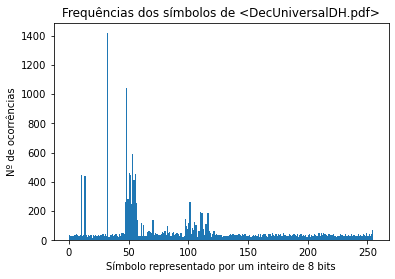

Iniciando a codificação da tabela...
Fim do processamento
Escrevendo no ficheiro : transmissao_DecUniversalDH.bin
Lendo o ficheiro : transmissao_DecUniversalDH.bin
Conteúdo do ficheiro : [ 15 242   0 ...  29  60 102]
Iniciando a descodificação da tabela...
9
256
Iniciar o cálculo da entropia...
Entropia : 7.04
Iniciar o cálculo do nº médio de bits por símbolo...
Nº médio de bits por símbolo : 7.07
Iniciar a eficiência do código...
Eficiência : 1.00
Fim da transmissão
Iniciar a transmissão do ficheiro : <csm_tp2_resources/DecUniversalDH.txt>
A construir a tabela de frequências...


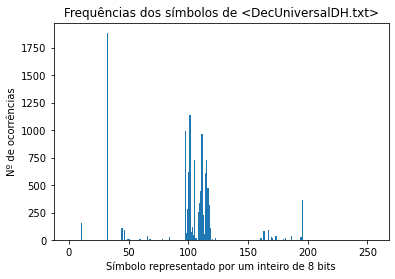

Iniciando a codificação da tabela...
Fim do processamento
Escrevendo no ficheiro : transmissao_DecUniversalDH.bin
Lendo o ficheiro : transmissao_DecUniversalDH.bin
Conteúdo do ficheiro : [168   4   0 ... 160  56 224]
Iniciando a descodificação da tabela...
8
65
Iniciar o cálculo da entropia...
Entropia : 4.42
Iniciar o cálculo do nº médio de bits por símbolo...
Nº médio de bits por símbolo : 4.45
Iniciar a eficiência do código...
Eficiência : 0.99
Fim da transmissão
Iniciar a transmissão do ficheiro : <csm_tp2_resources/HenryMancini-PinkPanther30s.mp3>
A construir a tabela de frequências...


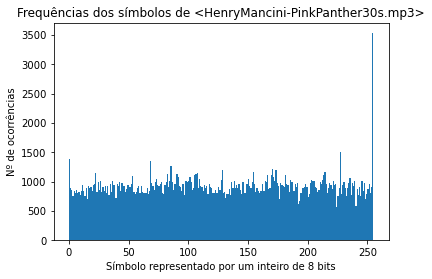

Iniciando a codificação da tabela...
Fim do processamento
Escrevendo no ficheiro : transmissao_HenryMancini-PinkPanther30s.bin
Lendo o ficheiro : transmissao_HenryMancini-PinkPanther30s.bin
Conteúdo do ficheiro : [175 255 240 ... 159 159 128]
Iniciando a descodificação da tabela...
9
256
Iniciar o cálculo da entropia...
Entropia : 7.98
Iniciar o cálculo do nº médio de bits por símbolo...
Nº médio de bits por símbolo : 7.99
Iniciar a eficiência do código...
Eficiência : 1.00
Fim da transmissão
Iniciar a transmissão do ficheiro : <csm_tp2_resources/HenryMancini-PinkPantherC.mid>
A construir a tabela de frequências...


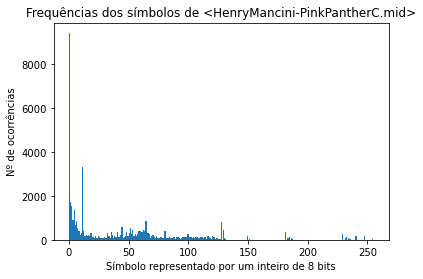

Iniciando a codificação da tabela...
Fim do processamento
Escrevendo no ficheiro : transmissao_HenryMancini-PinkPantherC.bin
Lendo o ficheiro : transmissao_HenryMancini-PinkPantherC.bin
Conteúdo do ficheiro : [ 12 160   0 ...  15 138 176]
Iniciando a descodificação da tabela...
9
203
Iniciar o cálculo da entropia...
Entropia : 5.99
Iniciar o cálculo do nº médio de bits por símbolo...
Nº médio de bits por símbolo : 6.02
Iniciar a eficiência do código...
Eficiência : 1.00
Fim da transmissão
Iniciar a transmissão do ficheiro : <csm_tp2_resources/LenaColor.tif>
A construir a tabela de frequências...


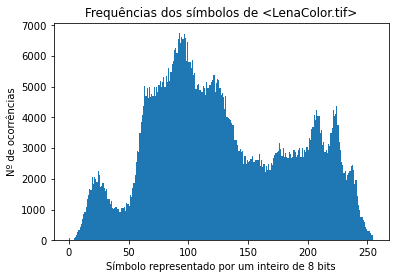

Iniciando a codificação da tabela...
Fim do processamento
Escrevendo no ficheiro : transmissao_LenaColor.bin
Lendo o ficheiro : transmissao_LenaColor.bin
Conteúdo do ficheiro : [ 79 245 192 ...  80 233 208]
Iniciando a descodificação da tabela...
9
256
Iniciar o cálculo da entropia...
Entropia : 7.75
Iniciar o cálculo do nº médio de bits por símbolo...
Nº médio de bits por símbolo : 7.78
Iniciar a eficiência do código...
Eficiência : 1.00
Fim da transmissão
Iniciar a transmissão do ficheiro : <csm_tp2_resources/LenaGray.tif>
A construir a tabela de frequências...


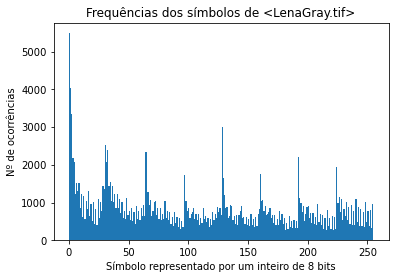

Iniciando a codificação da tabela...
Fim do processamento
Escrevendo no ficheiro : transmissao_LenaGray.bin
Lendo o ficheiro : transmissao_LenaGray.bin
Conteúdo do ficheiro : [ 79 240   0 ...   3  58  32]
Iniciando a descodificação da tabela...
9
256
Iniciar o cálculo da entropia...
Entropia : 7.76
Iniciar o cálculo do nº médio de bits por símbolo...
Nº médio de bits por símbolo : 7.79
Iniciar a eficiência do código...
Eficiência : 1.00
Fim da transmissão
Iniciar a transmissão do ficheiro : <csm_tp2_resources/circuitos.wav>
A construir a tabela de frequências...


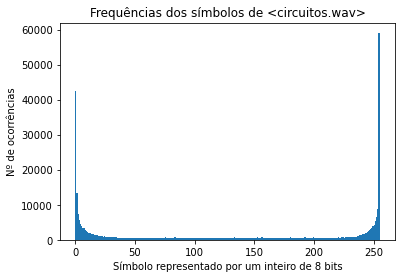

Iniciando a codificação da tabela...
Fim do processamento
Escrevendo no ficheiro : transmissao_circuitos.bin
Lendo o ficheiro : transmissao_circuitos.bin
Conteúdo do ficheiro : [ 15 255 240 ... 241 174 242]
Iniciando a descodificação da tabela...
9
256
Iniciar o cálculo da entropia...
Entropia : 6.78
Iniciar o cálculo do nº médio de bits por símbolo...
Nº médio de bits por símbolo : 6.79
Iniciar a eficiência do código...
Eficiência : 1.00
Fim da transmissão
Iniciar a transmissão do ficheiro : <csm_tp2_resources/PrimoLevi.docx>
A construir a tabela de frequências...


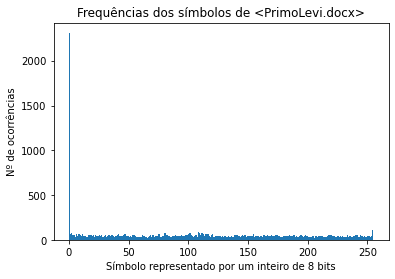

Iniciando a codificação da tabela...
Fim do processamento
Escrevendo no ficheiro : transmissao_PrimoLevi.bin
Lendo o ficheiro : transmissao_PrimoLevi.bin
Conteúdo do ficheiro : [ 79 240   0 ... 214 182 216]
Iniciando a descodificação da tabela...
9
256
Iniciar o cálculo da entropia...
Entropia : 7.35
Iniciar o cálculo do nº médio de bits por símbolo...
Nº médio de bits por símbolo : 7.38
Iniciar a eficiência do código...
Eficiência : 1.00
Fim da transmissão
Iniciar a transmissão do ficheiro : <csm_tp2_resources/Cash_flow.xlsx>
A construir a tabela de frequências...


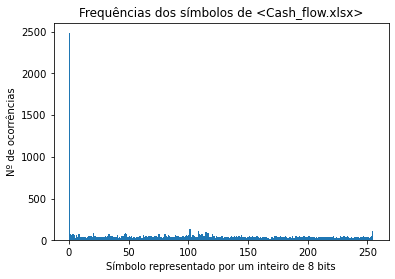

Iniciando a codificação da tabela...
Fim do processamento
Escrevendo no ficheiro : transmissao_Cash_flow.bin
Lendo o ficheiro : transmissao_Cash_flow.bin
Conteúdo do ficheiro : [ 79 240   0 ...  31 127 252]
Iniciando a descodificação da tabela...
9
256
Iniciar o cálculo da entropia...
Entropia : 7.21
Iniciar o cálculo do nº médio de bits por símbolo...
Nº médio de bits por símbolo : 7.25
Iniciar a eficiência do código...
Eficiência : 0.99
Fim da transmissão
Iniciar a transmissão do ficheiro : <csm_tp2_resources/modulo.JPG>
A construir a tabela de frequências...


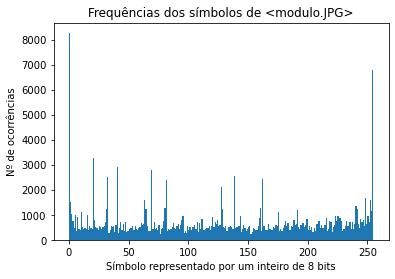

Iniciando a codificação da tabela...
Fim do processamento
Escrevendo no ficheiro : transmissao_modulo.bin
Lendo o ficheiro : transmissao_modulo.bin
Conteúdo do ficheiro : [239 240   0 ...   7 213 128]
Iniciando a descodificação da tabela...
9
256
Iniciar o cálculo da entropia...
Entropia : 7.66
Iniciar o cálculo do nº médio de bits por símbolo...
Nº médio de bits por símbolo : 7.69
Iniciar a eficiência do código...
Eficiência : 1.00
Fim da transmissão
Iniciar a transmissão do ficheiro : <csm_tp2_resources/circuito_logico.png>
A construir a tabela de frequências...


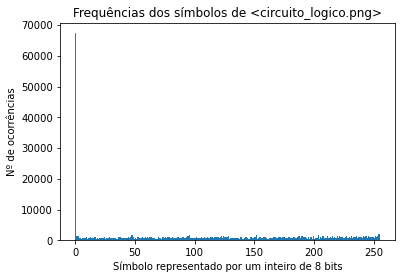

Iniciando a codificação da tabela...
Fim do processamento
Escrevendo no ficheiro : transmissao_circuito_logico.bin
Lendo o ficheiro : transmissao_circuito_logico.bin
Conteúdo do ficheiro : [ 15 240   0 ... 239 157 112]
Iniciando a descodificação da tabela...
9
256
Iniciar o cálculo da entropia...
Entropia : 6.92
Iniciar o cálculo do nº médio de bits por símbolo...
Nº médio de bits por símbolo : 6.94
Iniciar a eficiência do código...
Eficiência : 1.00
Fim da transmissão
Iniciar a transmissão do ficheiro : <csm_tp2_resources/CSM_tp1.ipynb>
A construir a tabela de frequências...


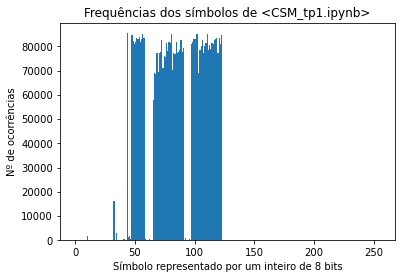

Iniciando a codificação da tabela...
Fim do processamento
Escrevendo no ficheiro : transmissao_CSM_tp1.bin
Lendo o ficheiro : transmissao_CSM_tp1.bin
Conteúdo do ficheiro : [205 197  96 ...  57 249   0]
Iniciando a descodificação da tabela...
8
111
Iniciar o cálculo da entropia...
Entropia : 6.03
Iniciar o cálculo do nº médio de bits por símbolo...
Nº médio de bits por símbolo : 6.03
Iniciar a eficiência do código...
Eficiência : 1.00
Fim da transmissão


In [ ]:
resultado_pdf = transmissao_huffman("csm_tp2_resources/DecUniversalDH.pdf", "DecUniversalDH", ".pdf", protocolo_tabela)
resultado_txt = transmissao_huffman("csm_tp2_resources/DecUniversalDH.txt", "DecUniversalDH", ".txt", protocolo_tabela)
resultado_mp3 = transmissao_huffman("csm_tp2_resources/HenryMancini-PinkPanther30s.mp3", "HenryMancini-PinkPanther30s", ".mp3", protocolo_tabela)
resultado_mid = transmissao_huffman("csm_tp2_resources/HenryMancini-PinkPantherC.mid", "HenryMancini-PinkPantherC", ".mid", protocolo_tabela)
resultado_tif1 = transmissao_huffman("csm_tp2_resources/LenaColor.tif", "LenaColor", ".tif", protocolo_tabela)
resultado_tif2 = transmissao_huffman("csm_tp2_resources/LenaGray.tif", "LenaGray", ".tif", protocolo_tabela)
resultado_wav = transmissao_huffman("csm_tp2_resources/circuitos.wav", "circuitos", ".wav", protocolo_tabela)
resultado_doc = transmissao_huffman("csm_tp2_resources/PrimoLevi.docx", "PrimoLevi", ".docx", protocolo_tabela)
resultado_xlsx = transmissao_huffman("csm_tp2_resources/Cash_flow.xlsx", "Cash_flow", ".xlsx", protocolo_tabela)
resultado_jpg = transmissao_huffman("csm_tp2_resources/modulo.JPG", "modulo", ".JPG", protocolo_tabela)
resultado_png = transmissao_huffman("csm_tp2_resources/circuito_logico.png", "circuito_logico", ".png", protocolo_tabela)
resultado_pynb = transmissao_huffman("csm_tp2_resources/CSM_tp1.ipynb", "CSM_tp1", ".ipynb", protocolo_tabela)

resultados = [resultado_pdf,resultado_txt,resultado_mp3,resultado_mid,resultado_tif1,resultado_tif2,resultado_wav,resultado_doc,resultado_xlsx,resultado_jpg, resultado_png,resultado_pynb]

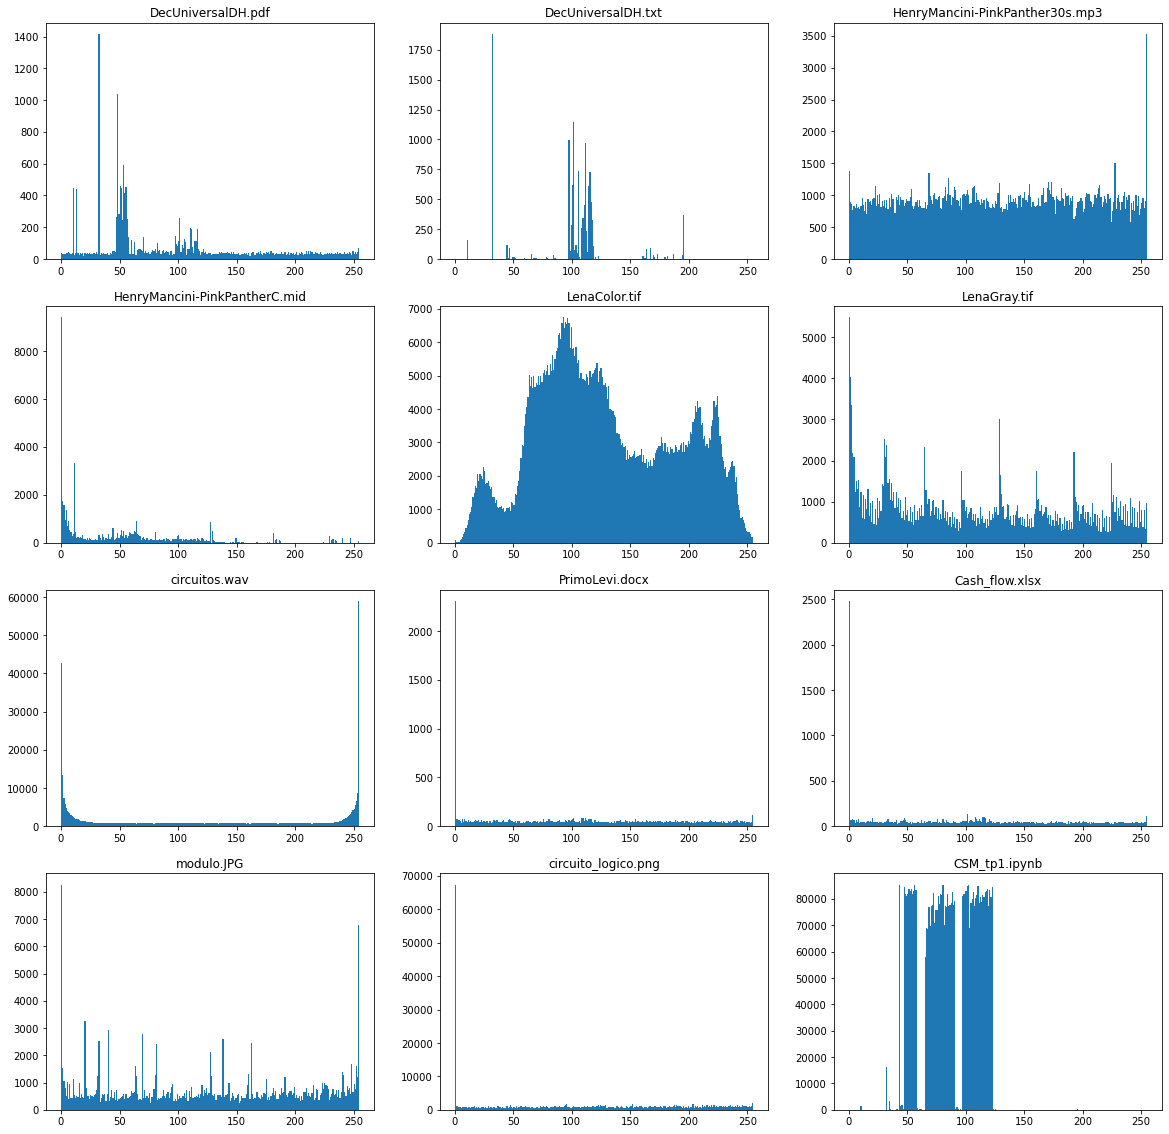

In [ ]:
fig, ax = plt.subplots(nrows=4, ncols=3, figsize=(20, 20))

#Plot to each different index
cont = 0
for axes in fig.axes:
    #print(resultados[cont][4])
    axes.hist(resultados[cont][4], 255, [0, 255]);
    axes.set_title(resultados[cont][0])
    cont += 1

Como podemos ver nos histogramas acima, para cada ficheiro existe uma distribuição de símbolos diferente.
Isto deve-se não só ao tipo do ficheiro mas também ao conteúdo do mesmo.
Olhando para os histogramas e sabendo como funciona um algoritmo de codificação entropica, conseguimos prever que a codificação Huffman irá permitir uma maior compressão em ficheiros como o ficheiro de texto e o jupyter notebook. Isto porque têm bastantes símbolos "abundantes", o que permite ao algoritmo alocar menos bits para codificar os mesmos. 

Ficheiros como o mp3 e o tif não vão tirar grande partido visto que não existe nenhum símbolo "abundante" bem definido, portanto o algoritmo Huffman irá tender a alocar o mesmo número de bits para os símbolos.

           Ficheiro              |      Entropia       | Nº médio bit p/Símbolo  |     Eficiencia      | Taxa Compressão
------------------------------------------------------------------------------------------------------------------------
HenryMancini-PinkPanther30s.mp3  |        7.98         |          7.99           |        1.0          |    1.0    
LenaGray.tif                     |        7.76         |          7.79           |        1.0          |    1.02   
LenaColor.tif                    |        7.75         |          7.78           |        1.0          |    1.03   
modulo.JPG                       |        7.66         |          7.69           |        1.0          |    1.04   
PrimoLevi.docx                   |        7.35         |          7.38           |        1.0          |    1.03   
Cash_flow.xlsx                   |        7.21         |          7.25           |        0.99         |    1.04   
DecUniversalDH.pdf               |        7.04         |      

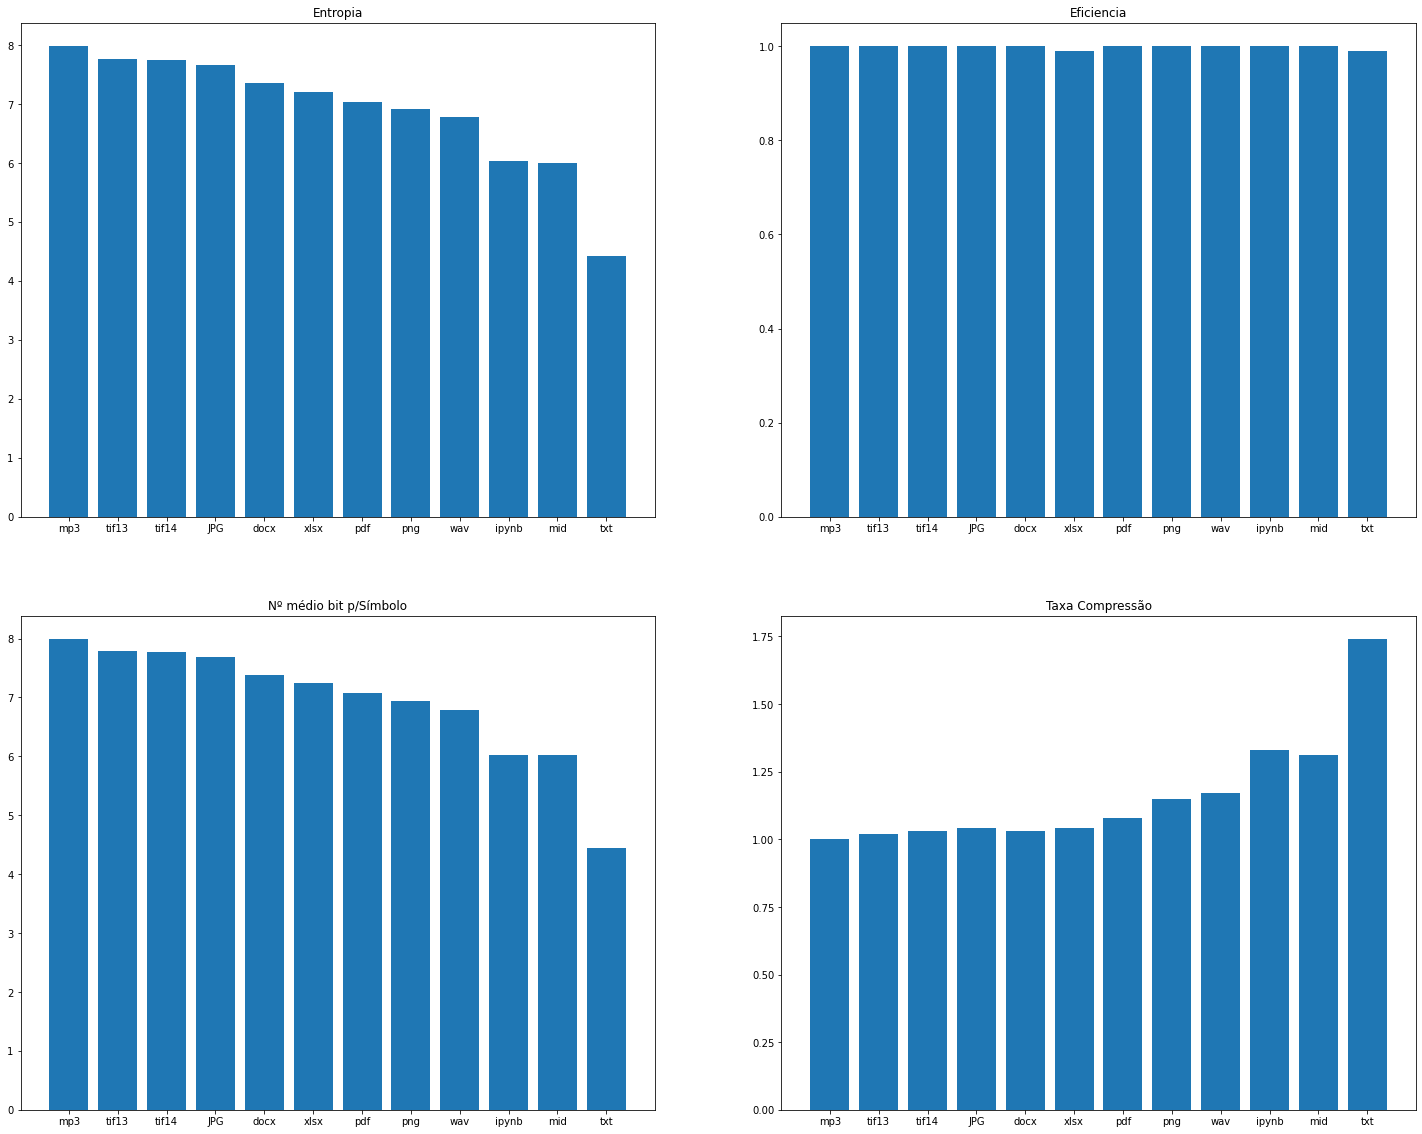

In [ ]:
# Tabela de resultados (Metricas)
# Cabeçalho
header = '{:^31}  |{:^20} | {:^23} |{:^20} | {:^10}'.format("Ficheiro", "Entropia", "Nº médio bit p/Símbolo", "Eficiencia" , "Taxa Compressão")
print(header)
print('-'*len(header))

titulos = [ "Entropia", "Nº médio bit p/Símbolo", "Eficiencia" , "Taxa Compressão"]
# Ordenar os ficheiros segundo o tempo de execução (ordem descendente)
ordem = np.empty(len(resultados))
for i in range(len(resultados)):
    ordem[i] = resultados[i][1][0]
ordem = np.argsort(ordem)[::-1]

# Formar a tabela de resultados
grafico = []
extensoes = []
for i in ordem:
    ficheiro = resultados[i][0]
    h = round(resultados[i][1][0], 2)
    l = round(resultados[i][1][1], 2)
    eficiencia = round(resultados[i][1][2], 2)
    taxa_compressao = round(resultados[i][3], 2)
    
    if(ficheiro.split(".")[-1] == 'tif'):
        cont += 1
        extensoes.append(ficheiro.split(".")[-1] + str(cont))
    else:
        extensoes.append(ficheiro.split(".")[-1])
    grafico.append([h, l, eficiencia,taxa_compressao])
    
    print('{:<31}  |{:^20} | {:^23} |{:^20} | {:^10}'.format(ficheiro, str(h), str(l), str(eficiencia), str(taxa_compressao)))

fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(25, 20))
cont = 0
grafico = np.array(grafico)
for i in range (len(grafico[0])):
    #print(resultados[cont][4])
    langs = extensoes
    values = grafico[:, i]
    ax[i%2][int((i)/2)].set_title(titulos[i])
    ax[i%2][int((i)/2)].bar(langs,values)
    cont += 1

Da análise dos resultados verifica-se que o ficheiro _.txt_ foi o que apresentou menor entropia e menor número de bits por símbolo, em contraste com o ficheiro de maior o .mp3. 

A entropia e o numero médio de bits por simbolo apresentam valores semelhantes.   
Isto acontece porque enquanto um ficheiro de áudio contem um número elevado de frequências únicas, o ficheiro de texto contém um número de caracteres limitado ao alfabeto ou linguagens usadas. Como sabemos que **numa codificação entrópica os símbolos mais abundantes recebem menos bits e os mais raros recebem mais bits**, então parece plausível o ficheiro de áudio ter uma entropia e nº médio de bits por símbolo superior ao ficheiro de texto, já que no ficheiro de texto existem muitos símbolos repetidos. Uma boa maneira de ver isso é analisando os histogramas disponibilizados acima.

Por fim em relação à eficiencia esta é um em todos os casos, com exceção do .xlsx e do .txt que é 0.99. Já a taxa de compressão apresentas valores entre 1 e 2 sendo o .txt o de maior compressão 1.74 e o .mp3 o de menor compressão (= 1 ou seja sem compressão).

Mais uma vez isto dá-se porque o algoritmo de Huffman, sendo uma codificação entrópica, funcionará melhor para ficheiros que tenham símbolos muito repetidos, já que aproveitará este facto para lhes atribuir menos bits e portanto reduzir o espaço que vão ocupar na versão comprimida. O ficheiro de som, não tendo o conceito de "mais abundante" bem definido, o algoritmo não vai conseguir fazer um trabalho suficientemente bom para fazer uma compressão notável do ficheiro.

   M - mensagem | T - tabela     |                                        Tempo de execução (ms)                                       
-------------------------------------------------------------------------------------------------------------------------------
           Ficheiro              |   Total   |  Cod. T   |  Cod. M   | Process M |  Write M  |  Read M   |  Dec. T   |  Dec. M   
-------------------------------------------------------------------------------------------------------------------------------
CSM_tp1.ipynb                    | 45482.26  |   2.45    | 36993.25  |  1755.82  |   1.49    |   5.95    |  2218.61  |  4504.69  
LenaColor.tif                    |  3992.8   |   5.98    |  1584.72  |  371.97   |   0.99    |   6.95    |  679.02   |  1343.17  
circuitos.wav                    |  1078.34  |   5.95    |  334.83   |  149.26   |    0.5    |   5.46    |  191.95   |  390.38   
circuito_logico.png              |  820.38   |   5.98    |   232.1   |  114.11   |   0.9

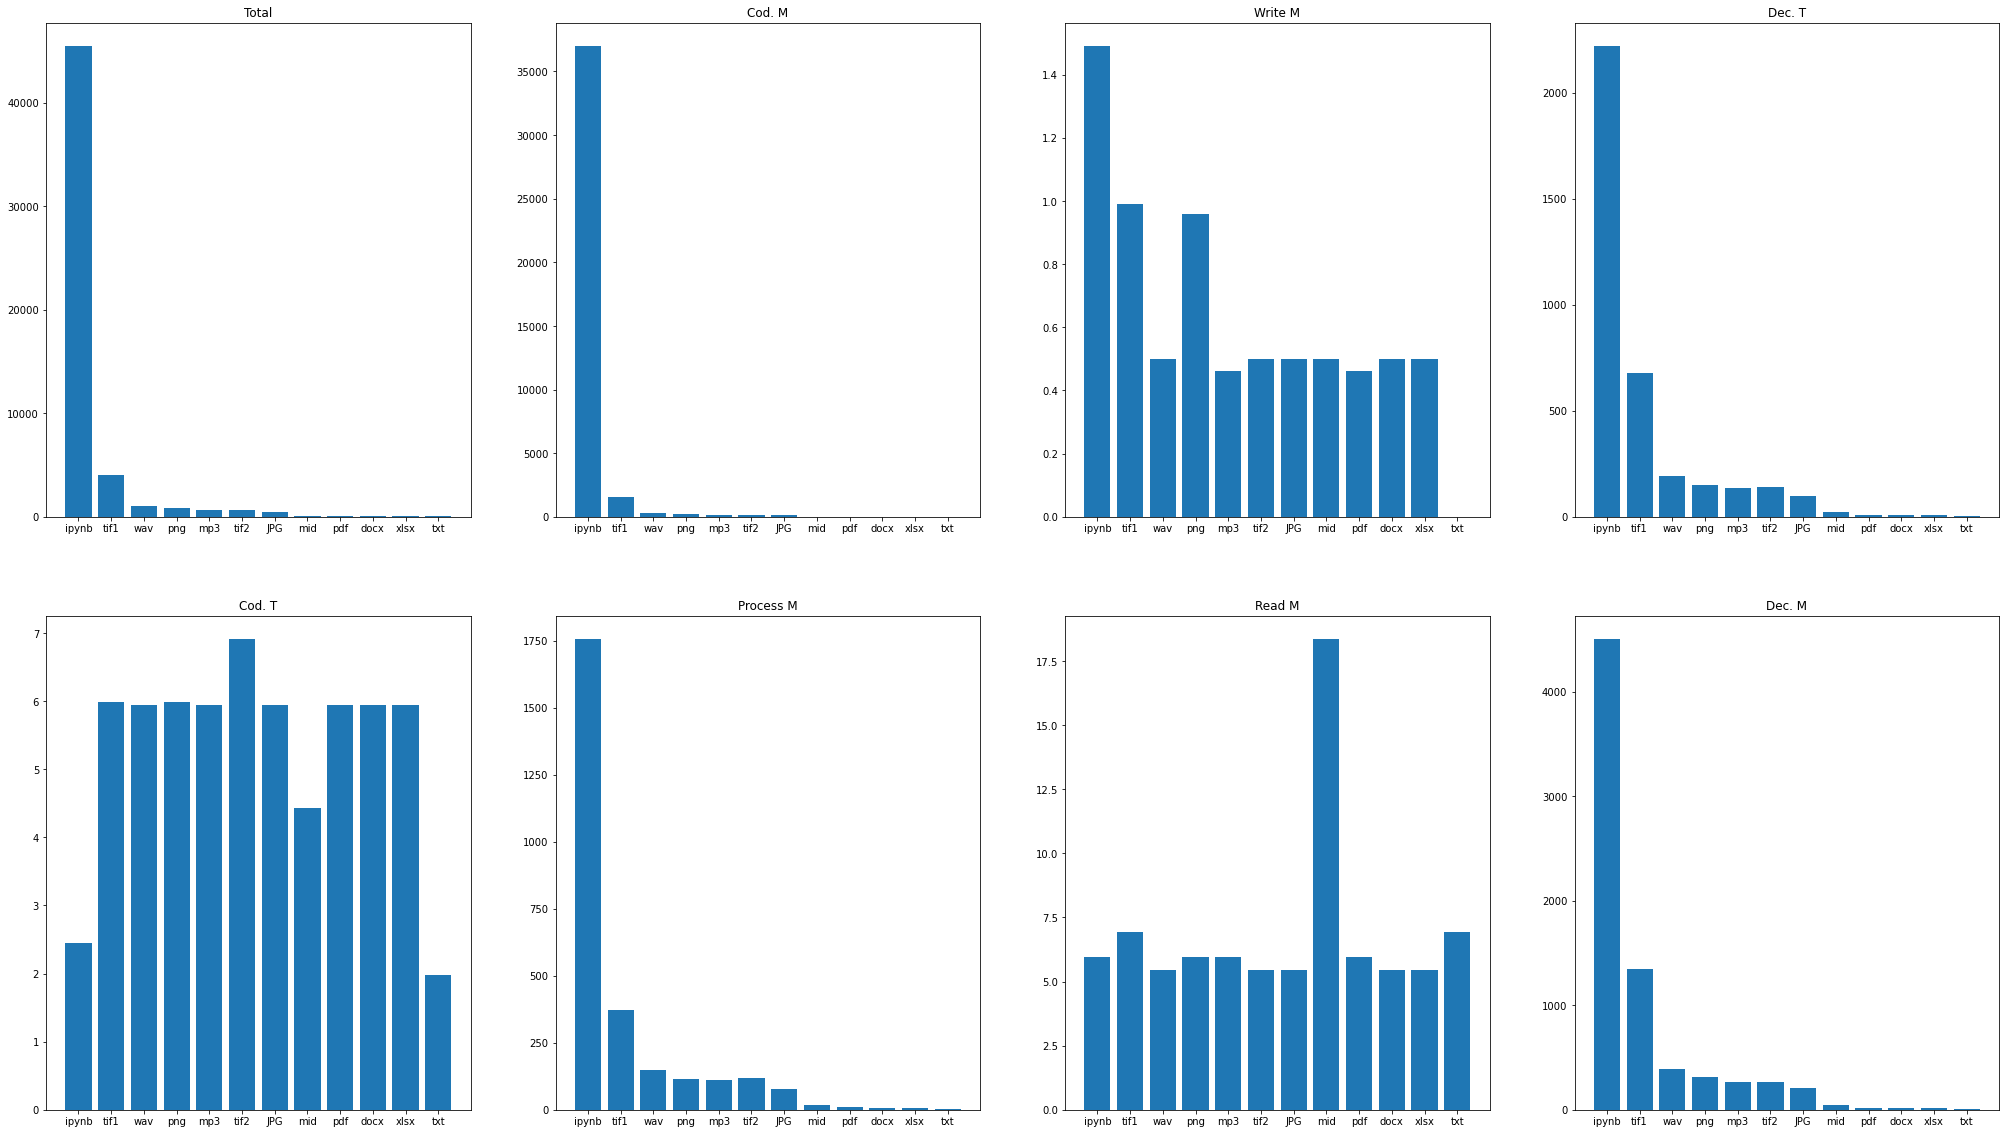

In [ ]:
# Tabela de resultados (Tempos de execucao)
# Cabeçalho
header = '{:^31}  |{:^11}|{:^11}|{:^11}|{:^11}|{:^11}|{:^11}|{:^11}|{:^11}'.format("Ficheiro", "Total", "Cod. T", "Cod. M" , "Process M", "Write M", "Read M", "Dec. T", "Dec. M")
print('{:^31}  | {:^100}'.format('M - mensagem | T - tabela', "Tempo de execução (ms)"))
print('-'*(len(header)-2))
print(header)
print('-'*(len(header)-2))
ordem = np.empty(len(resultados))
# Ordenar os ficheiros segundo o tempo de execução (ordem descendente)
for i in range(len(resultados)):
    ordem[i] = resultados[i][2][0]*1000
ordem = np.argsort(ordem)[::-1]

titulo = ["Total", "Cod. T", "Cod. M" , "Process M", "Write M", "Read M", "Dec. T", "Dec. M"]
graficos = []
extensoes = []
cont = 0 
# Formar a tabela de resultados
for i in ordem:
    ficheiro = resultados[i][0]
    t1 = round(resultados[i][2][0]*1000, 2)
    t2 = round(resultados[i][2][1]*1000, 2)
    t3 = round(resultados[i][2][2]*1000, 2)
    t4 = round(resultados[i][2][3]*1000, 2)
    t5 = round(resultados[i][2][4]*1000, 2)
    t6 = round(resultados[i][2][5]*1000, 2)
    t7 = round(resultados[i][2][6]*1000, 2)
    t8 = round(resultados[i][2][7]*1000, 2)
    
    if(ficheiro.split(".")[-1] == 'tif'):
        cont += 1
        extensoes.append(ficheiro.split(".")[-1] + str(cont))
    else:
        extensoes.append(ficheiro.split(".")[-1])
    t = [t1, t2, t3, t4, t5, t6, t7, t8]
    graficos.append(t)
    
    print('{:<31}  |{:^11}|{:^11}|{:^11}|{:^11}|{:^11}|{:^11}|{:^11}|{:^11}'.format(ficheiro, *t))


fig, ax = plt.subplots(nrows=2, ncols=4, figsize=(35, 20))
cont = 0
graficos = np.array(graficos)
for i in range (len(graficos[0])):
    #print(resultados[cont][4])
    langs = extensoes
    values = graficos[:, i]
    ax[i%2][int((i)/2)].set_title(titulo[i])
    ax[i%2][int((i)/2)].bar(langs,values)
    cont += 1

    #t.sort(reverse=True)
    

Agora vamos analizar os tempos de execução dos diferentes ficheiros. O de menor foi o .txt com apenas 27.93 total e o de maior foi o ficheiro .ipynb com 45542.39 total, em termos de etapas verifica-se que tanto a codificação como a descodificação da Mensagem correspondem às etapas de maior tempo, no entanto este varia segundo a extenção.